# Two-dimensional shallow water equations
### v1.42, 3 March 2016, by Brian Fiedler
### Modifications by Joseph France


**This should be the final version, for tasks due on Friday March 11, 2016**

We consider these *dimensionless* two-*dimensional* shallow-water equations:
$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} 
+ v \frac{\partial u}{\partial y}= - \frac{\partial h}{\partial x} + fv
$$

$$
\frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} 
+ v \frac{\partial v}{\partial y}= - \frac{\partial h}{\partial y} - fu
$$

$$
\frac{\partial h}{\partial t} = - \frac{\partial (uh) }{\partial x} - \frac{\partial (vh) }{\partial y}
$$

#### As explained in the previous notebook, the $^*$ to designate a variable to be dimensionless has been dropped, and left as implied. The above $f$ is acutally $f^*$, and is related to the familiar Coriolis parameter $f$ by:

$$
f^* = \frac{L}{\sqrt{gH}} f
$$

The boundary conditions for $u(x,y,t)$, $v(x,y,t)$ and $h(x,y,t)$ are:

$$
u(0,y,t)=0 \qquad u(1,y,t)=0 \qquad v(x,0,t)=0 \qquad v(x,1,t)=0
$$

$$
\frac{\partial h}{\partial x}(0,y,t)=0 \qquad \frac{\partial h}{\partial x}(1,y,t)=0
\qquad \frac{\partial h}{\partial y}(x,0,t)=0 \qquad \frac{\partial h}{\partial y}(x,1,t)=0
$$



In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display,clear_output
import time as Time
import math
import numpy as np
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
matplotlib.rcParams.update({'font.size': 22})
from IPython.core.display import HTML
HTML( open('my_css.css').read() )

In [3]:
# Expands the margins of a matplotlib axis, 
# and so prevents arrows on boundaries from being clipped. 
def stop_clipping(ax,marg=.02): # default is 2% increase
    l,r,b,t = ax.axis()
    dx,dy = r-l, t-b
    ax.axis([l-marg*dx, r+marg*dx, b-marg*dy, t+marg*dy])

In [4]:
# dqdt requires a list of the time derivatives for q, stored 
# in order from present to the past
def ab_blend(dqdt,order):
    if order==1:
        return dqdt[0]
    elif order==2:
        return 1.5*dqdt[0]-.5*dqdt[1]
    elif order==3:
        return (23*dqdt[0]-16*dqdt[1]+5*dqdt[2])/12.
    else:
        print("order", order ," not supported") 
              
def forback(q,dt,dqdt,dx,dy,fcoriolis): #q = [u,v,h], dqdt = [dudta[0],dvdta[0],dhdta[0]]
    hn = q[2] + dt*dqdt[2]
    un = q[0] + dt*dqdt[0]
    vn = q[1] + dt*dqdt[1]
    vn[0,:]=0.
    vn[-1,:]=0.
    hun = p2u(hn) # calculate h on the u grid
    dhdtn = -divergence(un*hun,vn*hun,dx,dy)
    dudtn,dvdtn = pgf(hn,dx,dy) #pressure gradient force
    dudtn += advect3(un,un,vn,dx,dy,'u') # no option for other than 3rd order 
    dvdtn += advect3(vn,un,vn,dx,dy,'v')
    dudtn += fcoriolis*vn
    dvdtn += -fcoriolis*un
    h = q[2] + dt*dhdtn
    u = q[0] + dt*dudtn
    v = q[1] + dt*dvdtn
    return [u,v,h]        

In [5]:
##############################################90% SURE THIS IS CORRECT
def p2u(p):
# interpolates and extrapolates from the p-grid to the u-grid
    u=np.zeros((p.shape[0]+1,p.shape[1]+1))
    u[1:-1,1:-1] = .25*( p[:-1,:-1]+p[1:,:-1]+p[1:,1:]+p[:-1:,1:] )
    u[1:-1,-1] = .25* (p[:-1,0] + p[1:,0] + p[:-1,-1] + p[1:,-1]) #Periodic?
    u[1:-1,0] = u[1:-1,-1]
    u[0,1:-1] = .5* (p[0,:-1] + p[0,1:]) #Fixed
    u[-1,1:-1] = .5* (p[-1,:-1] + p[-1,1:]) #Fixed
    u[0,0]= .5* (p[0,-1] + p[0,0]) #Fixed in vert, periodic in horiz
    u[-1,0]= .5* (p[-1,-1] + p[-1,0])
    u[0,-1]= u[0,0]
    u[-1,-1]= u[-1,0]
    return u
############################################################# CORRECT
def u2p(u):
# interpolates u-grid to the p-grid
    return .25*( u[:-1,1:] + u[1:,1:] + u[:-1,:-1] + u[1:,:-1])
############################################################# CORRECT
def divergence(u,v,dx,dy):
    div = .5*( u[:-1,1:] + u[1:,1:] - u[:-1,:-1] - u[1:,:-1])/dx + .5*( v[1:,:-1] + v[1:,1:] - v[:-1,:-1] - v[:-1,1:])/dy
    return div
############################################################# CORRECT
#STUDENTS: complete the vorticity function, which is very similar to divergence
def vorticity(u,v,dx,dy):
    vor = .5*( v[:-1,1:] + v[1:,1:] - v[:-1,:-1] - v[1:,:-1])/dx - .5*( u[1:,:-1] + u[1:,1:] - u[:-1,:-1] - u[:-1,1:])/dy
    return vor
#########################################################################NEW VERSION SHOULD BE CORRECT
# third-order upwind advection
def advect3Old(q,u,v,dx,dy): 
    
    dqdt=np.zeros(q.shape)
    
    dqmx=np.zeros(q.shape)
    dqpx=np.zeros(q.shape)
    dqmy=np.zeros(q.shape)
    dqpy=np.zeros(q.shape)
    
    #Upwind
    #dqmx[:,1] = -q[:,0] + q[:,1]
    dqmx[:,-1] = (q[:,-3] - 6*q[:,-2] + 3*q[:,-1] + 2*q[:,1])/6. 
    dqmx[:,0] = dqmx[:,-1]
    dqmx[:,1] = (q[:,-2] - 6*q[:,-1] + 3*q[:,1] + 2*q[:,2])/6. 
    dqmx[:,2] = (q[:,-1] - 6*q[:,1] + 3*q[:,2] + 2*q[:,3])/6. 
    dqmx[:,3:-1] = (q[:,1:-3] - 6*q[:,2:-2] + 3*q[:,3:-1] + 2*q[:,4:])/6. 
    
    #Downwind
    #dqpx[:,-2] = -q[:,-2] + q[:,-1] # 1st order (upwind side at right wall)
    dqpx[:,-2] = (-2*q[:,-3] - 3*q[:,-2] + 6*q[:,-1] -1*q[:,1])/6. 
    dqpx[:,-1] = (-2*q[:,-2] - 3*q[:,-1] + 6*q[:,1] -1*q[:,2])/6.
    dqpx[:,0] = dqpx[:,-1]
    dqpx[:,1] = (-2*q[:,-1] - 3*q[:,1] + 6*q[:,2] -1*q[:,3])/6. 
    dqpx[:,2:-2] = (-2*q[:,1:-3] - 3*q[:,2:-2] + 6*q[:,3:-1] -1*q[:,4:])/6. 

    dqmy[1,:]  = -q[0,:] + q[1,:] # 1st order (upwind side at bottom wall)
    dqmy[2:-1,:] =  (q[:-3,:] - 6*q[1:-2,:] + 3*q[2:-1,:] + 2*q[3:,:])/6. # 3rd order, minus side
    dqpy[-2,:] = -q[-2,:] + q[-1,:] # 1st order (upwind side at top wall)
    dqpy[1:-2,:] = ( - 2*q[0:-3,:]  - 3*q[1:-2,:] + 6*q[2:-1,:] - q[3:,:] )/6. # 3rd order, plus side

    dqdx=np.where(u>0.,dqmx,dqpx)/dx # upwind, emphasize side from where fluid is coming from
    dqdy=np.where(v>0.,dqmy,dqpy)/dy # ditto
    
    dqdt += -u*dqdx
    dqdt += -v*dqdy
    
    return dqdt

def advect3(q,u,v,dx,dy,periodic): 
# 3rd-order upwind advection
# q,u,v are co-located
    
    sh = q.shape
    Q = np.zeros( (sh[0],sh[1]+4) )
    Q[:, 2:-2 ] = q
     
    if periodic=='U' or periodic=='u':        
        Q[ : , :2] = q[ : , -3:-1 ]
        Q[ : , -2:] = q[ :, 1:3 ]
    elif periodic=='v' or periodic=='w' or periodic=='b':
        Q[ : , :2 ]  = q[ : , -2: ]
        Q[ : , -2: ] = q[ : , :2 ] 
    
    dqdt=np.zeros(sh)
    dqmx=np.zeros(sh)
    dqpx=np.zeros(sh)
    dqmy=np.zeros(sh)
    dqpy=np.zeros(sh)

# "m" is difference biased to the minus side, "p" to the plus side
# must use first order "#1" if too close to wall
    
    dqmx[:,:] =  (2*Q[:,3:-1] + 3*Q[:,2:-2] - 6*Q[:,1:-3] + Q[:,:-4])/6. 
    dqpx[:,:] = -(2*Q[:,1:-3] + 3*Q[:,2:-2] - 6*Q[:,3:-1] + Q[:,4:] )/6.

    dqmy[-1,:] = q[-1,:]-q[-2,:]  #1
    dqmy[1,:]  = q[1,:]-q[0,:]  #1
    dqmy[2:-1,:] = (2*q[3:,:]+3*q[2:-1,:]-6*q[1:-2,:]+q[:-3,:])/6. #3
    dqpy[0,:] = q[1,:]-q[0,:]  #1
    dqpy[-2,:] = q[-1,:]-q[-2,:] #1
    dqpy[1:-2,:] = -(2*q[:-3,:]+3*q[1:-2,:]-6*q[2:-1,:]+q[3:,:])/6. #3

# use derivatives biased to the upwind side:
    dqdx=np.where(u>0.,dqmx,dqpx)/dx
    dqdy=np.where(v>0.,dqmy,dqpy)/dy

# advective terms:
    dqdt+=-u*dqdx
    dqdt+=-v*dqdy
    
    return dqdt

#####################################WORKS
def pgfOld(p,dx,dy):
# calculated pressure gradient force on the u-grid
# note calculation on the boundaries assume pressure gradient force
# along boundary is the same as calculated 1/2 a grid point away from the boundary
    dudt=np.zeros( (p.shape[0]+1, p.shape[1]+1 ) ) #initialize an array on the u-grid
    dvdt=np.zeros( dudt.shape ) # ditto

    dpy =  p[1:,:]-p[:-1,:] # delta p in the x direction
    dvdt[1:-1,1:-1] = -.5* ( dpy[:,:-1] + dpy[:,1:] ) /dy #average to put on u-grid
    dvdt[1:-1,0] =  -dpy[:,0] /dy #dvdt along left boundary
    dvdt[1:-1,-1] = dvdt[1:-1,0]
    #dvdt[1:-1,-1] = -dpy[:,-1] /dy #dvdt along right boundary

    dpx = p[:,1:]-p[:,:-1] # delta p in the y direction
    dudt[1:-1,1:-1] = -.5* ( dpx[:-1,:] + dpx[1:,:] ) /dx #average to put on u-grid
    dudt[1:-1,0] =  -.5* ( dpy[:,-1] + dpy[:,1] ) /dy #dvdt along left boundary
    dudt[1:-1,-1] = dudt[1:-1,0] #dvdt along right boundary
    #dudt[0,1:-1] =  -dpx[0,:] /dx #dudt along bottom boundary
    #dudt[-1,1:-1] = -dpx[-1,:] /dx #dudt along top boundary

    return dudt,dvdt

def pgf(p,dx,dy): 

    dudt=np.zeros( (p.shape[0]+1, p.shape[1]+3) )
    #dudt=np.zeros( (p.shape[0]+1, p.shape[1]+1) )
    dvdt=np.zeros( dudt.shape )
    
    P = np.zeros( (p.shape[0] , p.shape[1]+2 ) )
    P[:,1:-1] = p
    P[:,0] = p[:,-1]
    P[:,-1] = p[:,0]
    
    #Nowhere in the dudt section does it handle dudt[0,1:-1] or dudt=[-1,1:-1] (Top and bot)
    #Nowhere in the dvdt section does it handle dvdt[1:-1,0] or dudt=[1:-1,-1] (left and right)
    #therefore no change in u along top and bottom boundary, so u is always 0 there
    #Since the base u field is 0, dudt from this is = to f*u.
    dpx = (P[:,1:]-P[:,:-1])/dx 
    dudt[1:-1,1:-1] = -.5*(dpx[1:,:] + dpx[:-1,:])   
    dudt[1:-1,-1] = -.5*(dpx[1:,-1] + dpx[:-1,1])
    dudt[1:-1,0] = dudt[1:-1,-1]
    dudt[0,1:-1] =  -dpx[0,:]
    dudt[-1,1:-1] = -dpx[-1,:]
    dudt[0,0] = -.5*(dpx[0,0] + dpx[0,1])
    dudt[0,-1] = dudt[0,0]
    dudt[-1,0] = -.5*(dpx[-1,0] + dpx[-1,1])
    dudt[-1,-1] = dudt[-1,0]
    
    dpy =  (P[1:,:]-P[:-1,:])/dy 
    dvdt[1:-1,1:-1] = -.5*(dpy[:,1:] + dpy[:,:-1])    
    dvdt[1:-1,-1] = -.5*(dpy[:,-1] + dpy[:,1])
    dvdt[1:-1,0] = dvdt[1:-1,-1]
    dvdt[0,0] = -dpy[0,0]
    dvdt[0,-1] = dvdt[0,0]
    dvdt[-1,0] = -dpy[-1,0]
    dvdt[-1,-1] = dvdt[-1,0]
    
    return dudt[:,1:-1],dvdt[:,1:-1] #[1:-1,1:-1]

In [6]:
# make the grid
Nx = 401 # number of x grid points for u
Ny = 101
xmax = 4. # 0 <= x <= xmax
ymax = 1.
dx = xmax/(Nx-1.) # grid width
print(dx)
dy = ymax/(Ny-1.)
x1u = np.linspace(0,xmax,Nx)
y1u = np.linspace(0,ymax,Ny)
x1p = .5*(x1u[:-1]+x1u[1:])
y1p = .5*(y1u[:-1]+y1u[1:])
# We need 2-D arrays of grid point coordinates, for plotting:
xu,yu = np.meshgrid(x1u,y1u) # x and y locations on the u-grid
xp,yp = np.meshgrid(x1p,y1p) # x and y locations on the p-grid

0.01


In [7]:
print(xu.shape)
print(xu)

(101, 401)
[[ 0.    0.01  0.02 ...,  3.98  3.99  4.  ]
 [ 0.    0.01  0.02 ...,  3.98  3.99  4.  ]
 [ 0.    0.01  0.02 ...,  3.98  3.99  4.  ]
 ..., 
 [ 0.    0.01  0.02 ...,  3.98  3.99  4.  ]
 [ 0.    0.01  0.02 ...,  3.98  3.99  4.  ]
 [ 0.    0.01  0.02 ...,  3.98  3.99  4.  ]]


In [8]:
print(xp.shape)
print(xp)

(100, 400)
[[ 0.005  0.015  0.025 ...,  3.975  3.985  3.995]
 [ 0.005  0.015  0.025 ...,  3.975  3.985  3.995]
 [ 0.005  0.015  0.025 ...,  3.975  3.985  3.995]
 ..., 
 [ 0.005  0.015  0.025 ...,  3.975  3.985  3.995]
 [ 0.005  0.015  0.025 ...,  3.975  3.985  3.995]
 [ 0.005  0.015  0.025 ...,  3.975  3.985  3.995]]


In [9]:
print(yu.shape)
print(yu)

(101, 401)
[[ 0.    0.    0.   ...,  0.    0.    0.  ]
 [ 0.01  0.01  0.01 ...,  0.01  0.01  0.01]
 [ 0.02  0.02  0.02 ...,  0.02  0.02  0.02]
 ..., 
 [ 0.98  0.98  0.98 ...,  0.98  0.98  0.98]
 [ 0.99  0.99  0.99 ...,  0.99  0.99  0.99]
 [ 1.    1.    1.   ...,  1.    1.    1.  ]]


Note the convention of meshgrid and matplotlib:  The **first** index controls the variation of $y$, the **second** index controls the variation of $x$. That protocol will also be true for all of our 2-D fields. This may be confusing because when normally write $h(x,y)$ we might expect in a python array `h[j,i]` that `i` controls the y-coordinate, but in fact `i` controls the x-coordinate.

In [10]:
print("x:" ,xu[1,1], xu[1,2])
print("y:" ,yu[1,1], yu[1,2])

x: 0.01 0.02
y: 0.01 0.01


In [11]:
def yhat(y,yc,w):
    return (y-yc)/w

In [12]:
#SCALES
t_scale = 0.5 #days
L_scale = 12.0*(10**6) #m
g = 10. #ms-1
H_scale = 3000. #m
c_scale = math.sqrt(g*H_scale) #ms-1
#DIMENSIONAL
beta = 2.0*(10**(-11)) #s-1 m-1
uo = 80. #ms-1
a = 6.0*(10**6) #m
w = a/4.0 #m
yc = a #m
xc = 4.*a #m
ho = 3000.0 #m
hm = 120.0 #m
wx = 1.5*(10**6) #m
wy = 2.0*(10**6) #m
tstop = 20 #days
#DIMENSIONLESS
beta = beta / (c_scale/(L_scale**2))
# initialize u, v, h
yc = yc / L_scale # center of jet
xc = xc / L_scale
xpc = xc*(Nx-1) #coordinate center of perturbation
ypc = (Ny-1)*yc #coordinate center of perturbation
w = w / L_scale #half width of the jet
wx = wx / L_scale #scaling width of perturbation
wy = wy / L_scale #scaling width of perturbation
uo = uo / c_scale #max velocity of jet
ho = ho / H_scale #minimum shallow water height
hm = hm / H_scale #perturbation maximum height
tstop = tstop / t_scale
pshape = yp.shape
ushape = yu.shape
ui = np.zeros(ushape) #u initial
hi = np.zeros(pshape) #h initial
hip = np.zeros(pshape) #h initial perturbed

uyhat = yhat(yu,yc,w)
pyhat = yhat(yp,yc,w)


#initial v
vi = 0.0*yu 

#initial u - Geosrophically Balanced Jet
for ycor in range(ushape[0]):
    for xcor in range(ushape[1]):
        uyv = uyhat[ycor,xcor]
        if uyv >= -1 and uyv <= 1:
            ui[ycor,xcor] = uo*(1-3*uyv**2 + 3*uyv**4 - uyv**6)
        else:
            ui[ycor,xcor] = 0.0
        
#initial h  - Geosrophically Balanced Jet
for ycor in range(pshape[0]):
    for xcor in range(pshape[1]):
        pyv = pyhat[ycor,xcor]
        if pyv <= -1 :
            hi[ycor,xcor] = ho
        elif pyv <= 1 and pyv >= -1 :
            hi[ycor,xcor] = ho - (w*beta*uo)*(yc*((16/35)+pyv-pyv**3+(3/5)*pyv**5-(1/7)*pyv**7)+w*((-1/8)+(1/2)*pyv**2-(3/4)*pyv**4+(1/2)*pyv**6-(1/8)*pyv**8))
        else:
            hi[ycor,xcor] = ho - (32/35)*(w*beta*uo*yc)
            
#initial h - Perturbation
testmode = 'P' #set A for analytical, anything else to perturb it
if testmode == 'A':
    hip = hi
else:
    for ycor in range(pshape[0]):
        for xcor in range(pshape[1]):
            pyv = pyhat[ycor,xcor]
            hip[ycor,xcor] = hi[ycor,xcor] + hm*(math.cos(math.pi*0.5*pyv)**2)*(math.exp(-((xcor/(Ny-1)-xc)/wx)**2))*(math.exp(-((ycor/(Ny-1)-yc)/wy)**2))

print(hip.shape,ui.shape)
print(xc,yc)

(100, 400) (101, 401)
2.0 0.5


In [13]:
##SET SCHEME TO USE FOR A NEW RUN

aborder = 10 # Adams-Bashforth order: 1, 2 or 3 [Set to 10 for Forwards-Backwards]
varStep = True
highres = False
fnamestr = "FB_Var4_CFL0p1"



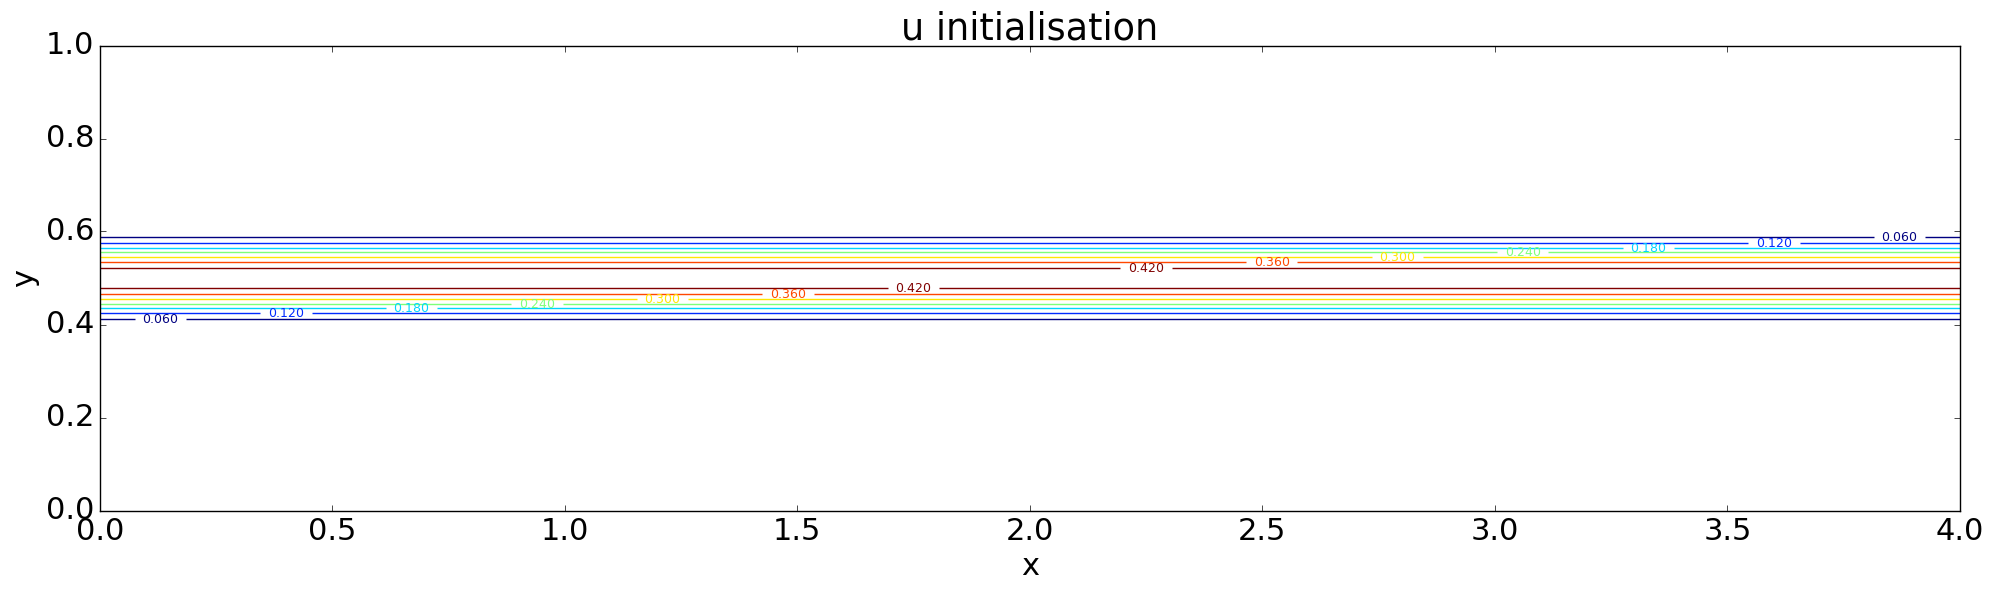

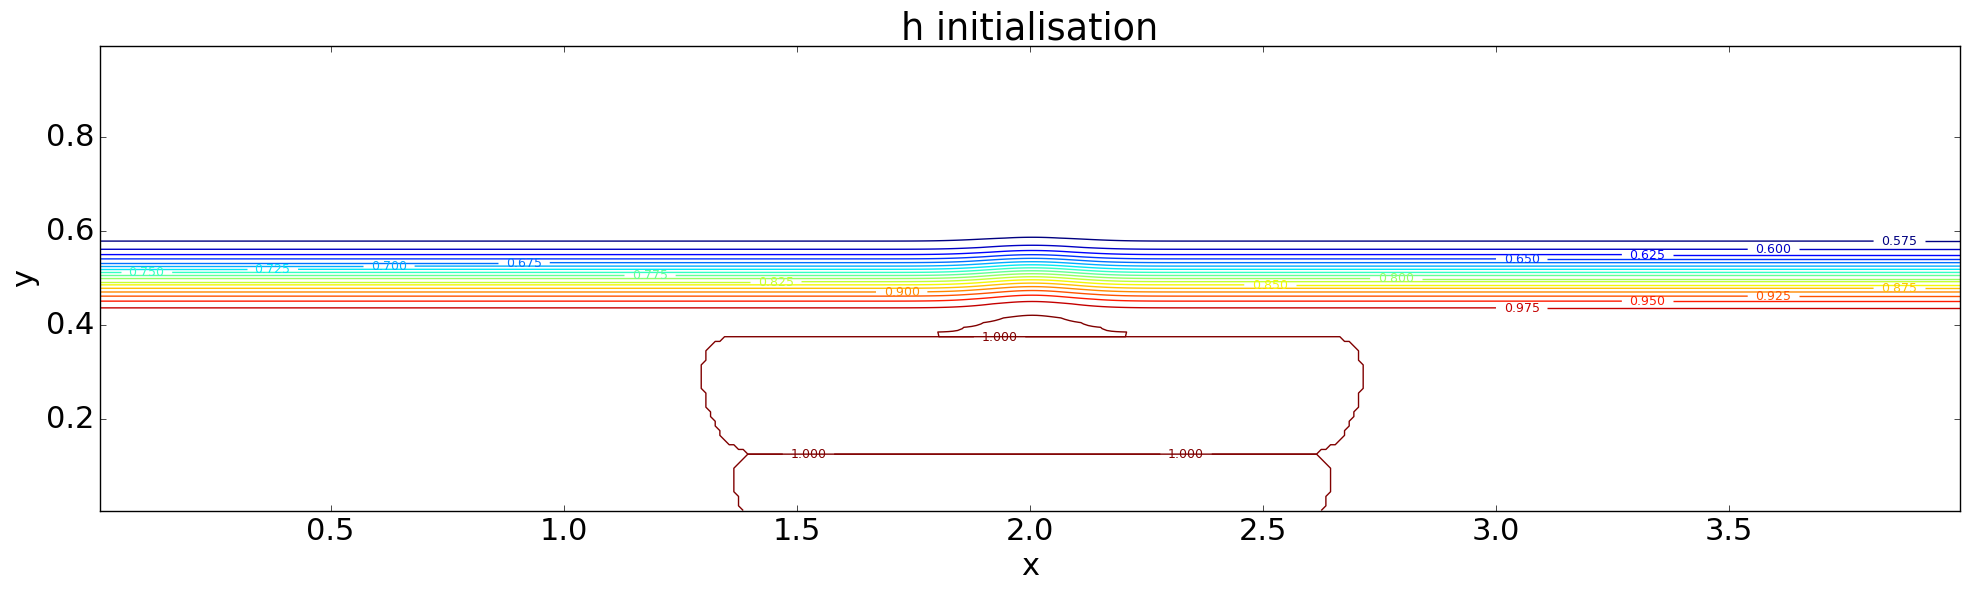

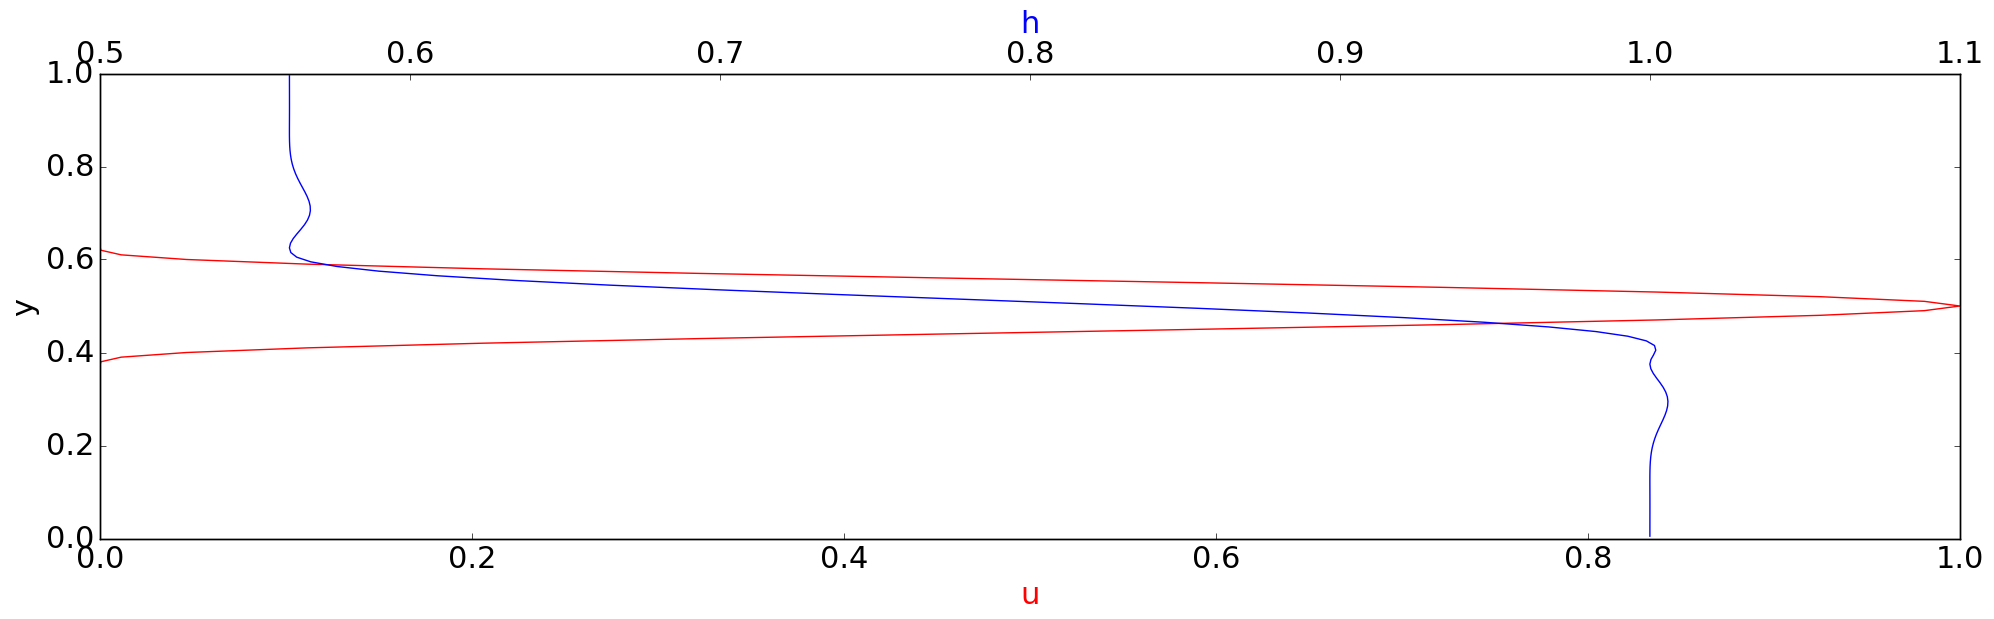

In [14]:
quicku,simpleu = plt.subplots(figsize=(24,6))
CHu = simpleu.contour(xu,yu,ui) #must assign a variable name to the contour plot
plt.clabel(CHu, fontsize=9, inline=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('u initialisation')
plt.savefig('initialu'+fnamestr+'.png')
quickh,simpleh = plt.subplots(figsize=(24,6))
CHh = simpleh.contour(xp,yp,hip,20) #must assign a variable name to the contour plot
plt.clabel(CHh, fontsize=9, inline=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('h initialisation')
plt.savefig('initialh'+fnamestr+'.png')
quickb,simpleb1 = plt.subplots(figsize=(24,6))
simpleb1.plot(ui[:,200]/uo,yu[:,200],'r-')
simpleb1.set_xlabel('u',color='r')
simpleb1.set_ylabel('y')
simpleb2 = simpleb1.twiny()
simpleb2.plot(hip[:,200]/ho,yp[:,200],'b-')
simpleb2.set_xlabel('h',color='b');
plt.savefig('initialuh'+fnamestr+'.png')



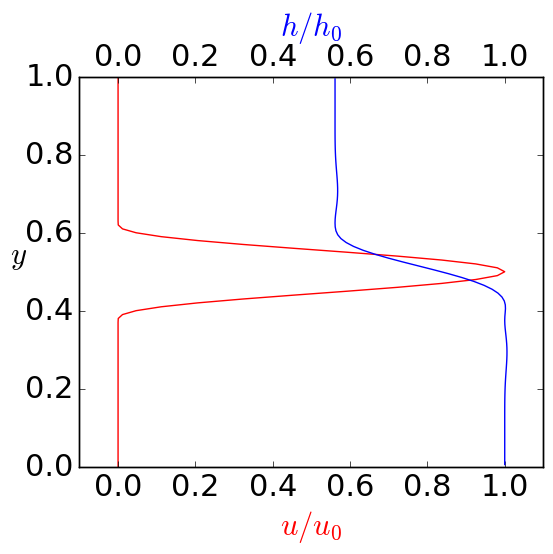

In [15]:
quick2,simpleb3 = plt.subplots(figsize=(6,6))
simpleb3.plot(ui[:,200]/uo,yu[:,200],'r-')
simpleb3.set_xlabel('$u/u_0$',color='r')
simpleb3.set_ylabel('$y$',rotation=360)
simpleb4 = simpleb3.twiny()
simpleb4.plot(hip[:,200]/ho,yp[:,200],'b-')
simpleb4.set_xlabel('$h/h_0$',color='b')
simpleb3.set_xlim(-0.1,1.1)
simpleb4.set_xlim(-0.1,1.1)
plt.tight_layout()
plt.savefig('initialuhSquare'+fnamestr+'.png')


In [17]:
# needed for contour plots of h in the animation:
lowc = -0.0001 #*(L_scale/c_scale) #lowest contour
hic = -lowc #highest contour
dc = 0.00001 #*(L_scale/c_scale)  #contour increment
mylevs = [] #store contours
lev = lowc
while lev < hic + 0.1*dc:
    mylevs.append(lev)
    lev += dc
    
#for arrow plots:
vd = 0 # vector skip (vd=1 plots all arrows)
speedmax = 0.05 # anticipated maximum speed

In [363]:
#fcoriolis = 1
fcoriolis = beta*yu[:,:]
speedmax = 1.
cfl = .1 #Anything over .34 blows up, .34 is pushing the limit of stability - determined experimentally when speedmax=1
dt = cfl*dx/speedmax
#cphase = 1.
#u_est = .6
#dtlim = .3 # fraction of a grid space a wave is allowed to travel in one time unit CHANGE THIS TO CHANGE dt - "Courant Number"
#dt = (dtlim *dx)/max(cphase,u_est,max(ui[:,200]))
#dt = dtlim *dx # because wave speed is 1

#courant = (max(cphase,u_est,max(ui[:,200]))*dt)/dx + (max(cphase,u_est,max(ui[:,200]))*dt)/dy
#print(courant)

#fdt_crit = 0.5 #determined by experimentation, crit value when dtlim = 0.2

#dt = min(fdt_crit/beta,dt) #force fdt <= fdt_crit 

dplot =  .1 # time increment between plots

#Variable Stepping
nsteps = int(tstop / dt)+1
mult = 4 #lambda^nsteps
c = mult**(1/nsteps)
dti = tstop*((c-1)/(mult-1))
maxdt = dti*c**(nsteps-1)

if aborder == 10:
    maxCFL=0.51
elif aborder == 3:
    maxCFL=0.34
if speedmax*dt/dx <= maxCFL: print("CFL Test Passed For Constant")
else: print("CFL Test FAILED For Constant")
if speedmax*dti/dx <= maxCFL: print("CFL Test Passed For Initial Variable")
else: print("CFL Test FAILED For Initial Variable")
if speedmax*maxdt/dx <= maxCFL: print("CFL Test Passed For Final Variable")
else: print("CFL Test FAILED For Final Variable")

if aborder != 10:
    varStep = False
if aborder == 3 and highres:
    expt = '%d,%.3f,%d,%d,%d,%d,%.6f,%.3f' % (aborder, cfl, beta, Ny, Nx, nsteps, dt, dt*t_scale*24*60*60) + 's ,' +str(varStep)
elif aborder == 3 and not highres:
    expt = '%d,%.3f,%d,%d,%d,%d,%.5f,%.3f' % (aborder, cfl, beta, Ny, Nx, nsteps, dt, dt*t_scale*24*60*60) + 's ,' +str(varStep)
elif aborder == 10 and varStep:
    expt = '%d,%.3f,%d,%d,%d,%d,%.5f,%.3f' % (aborder, cfl, beta, Ny, Nx, nsteps, dti, dti*t_scale*24*60*60) + 's ,' +str(varStep)
elif aborder == 10 and not varStep:
    expt = '%d,%.3f,%d,%d,%d,%d,%.5f,%.3f' % (aborder, cfl, beta, Ny, Nx, nsteps, dt, dt*t_scale*24*60*60) + 's ,' +str(varStep)
print(expt)
print(beta,dt,dt*beta)

CFL Test Passed For Constant
CFL Test Passed For Initial Variable
CFL Test Passed For Final Variable
10,0.100,16,101,401,40001,0.00046,19.962s ,True
16.62768775266122 0.001 0.01662768775266122


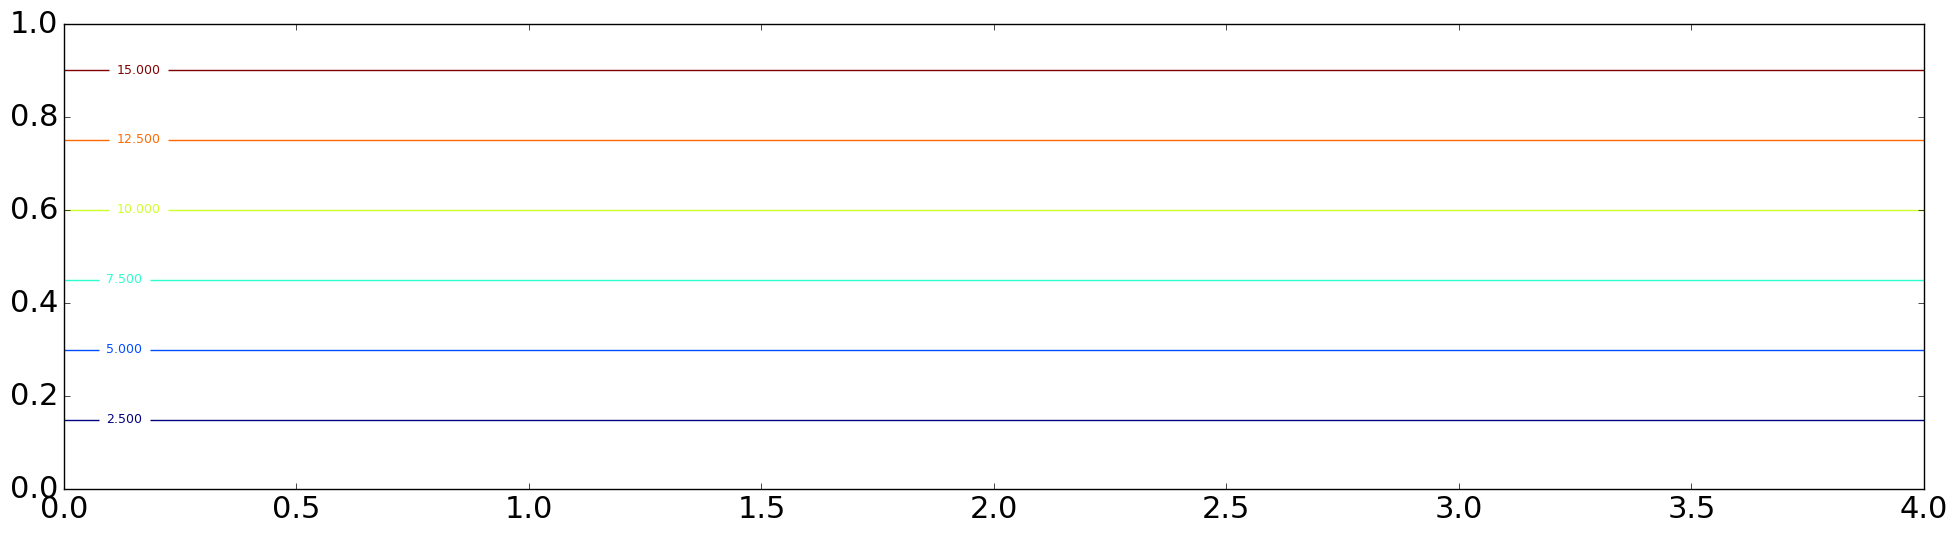

In [364]:
quick,simple3 = plt.subplots(figsize=(24,6))
CH3 = simple3.contour(xu,yu,fcoriolis) #must assign a variable name to the contour plot
plt.clabel(CH3, fontsize=9, inline=1);

In [365]:
def plot(xp,yp,h,mylevs,xu,vd,yu,u,ymax,xmax,v,speedmax,expt,mycmap,fnamestr):
    ax2.clear()
    CF=ax2.contourf(xp,yp,h,mylevs,zorder=1,extend="both",cmap=mycmap)
    ax2.set_yticklabels([])
    ax2.set_xticklabels([])
    ax2.xaxis.set_ticks_position('none') 
    ax2.yaxis.set_ticks_position('none') 
    if vd != 0:
        Q=ax2.quiver(xu[::vd,::vd],yu[::vd,::vd],u[::vd,::vd]*ymax/xmax,v[::vd,::vd],scale=speedmax*Nx/vd,units='width',zorder=3) #normally ymax/xmax =1 
        stop_clipping(ax2)
        ax2.quiverkey(Q,-.055,.95,speedmax,'{0:7.3f}'.format(speedmax),zorder=4)
    ax2.text(.3,-.05,expt,fontsize=16)
    ax2.text(.05,-.05,'t={0:5.3f}'.format(t),fontsize=16) 
    if t<dt/2.: 
        mycbar = myfig.colorbar(CF,ax=ax3,fraction=0.4)
        mycbar.ax.yaxis.set_ticks_position('left')
        sooner = mycbar.ax.yaxis.get_ticklabels()
        mycbar.set_label('Relative Vorticity / $s^{-1}$')
        for boomer in sooner:
            boomer.set_fontsize(12)
    clear_output(wait=True)
    display(myfig) 
    timestr = '%.1f' % t
    myfig.savefig(fnamestr+'_'+timestr+'_time.png')
    #Time.sleep(2.)

##  Notes about the simulation below.

* Note that wind vectors only every 2nd grid point is plotted, meaning that there are 2 times as many grid points as displayed vectors.  

* The simulation is a bit slow to compute. One reason is that the time step is limited by the gravity waves, which move with speed of 1. 

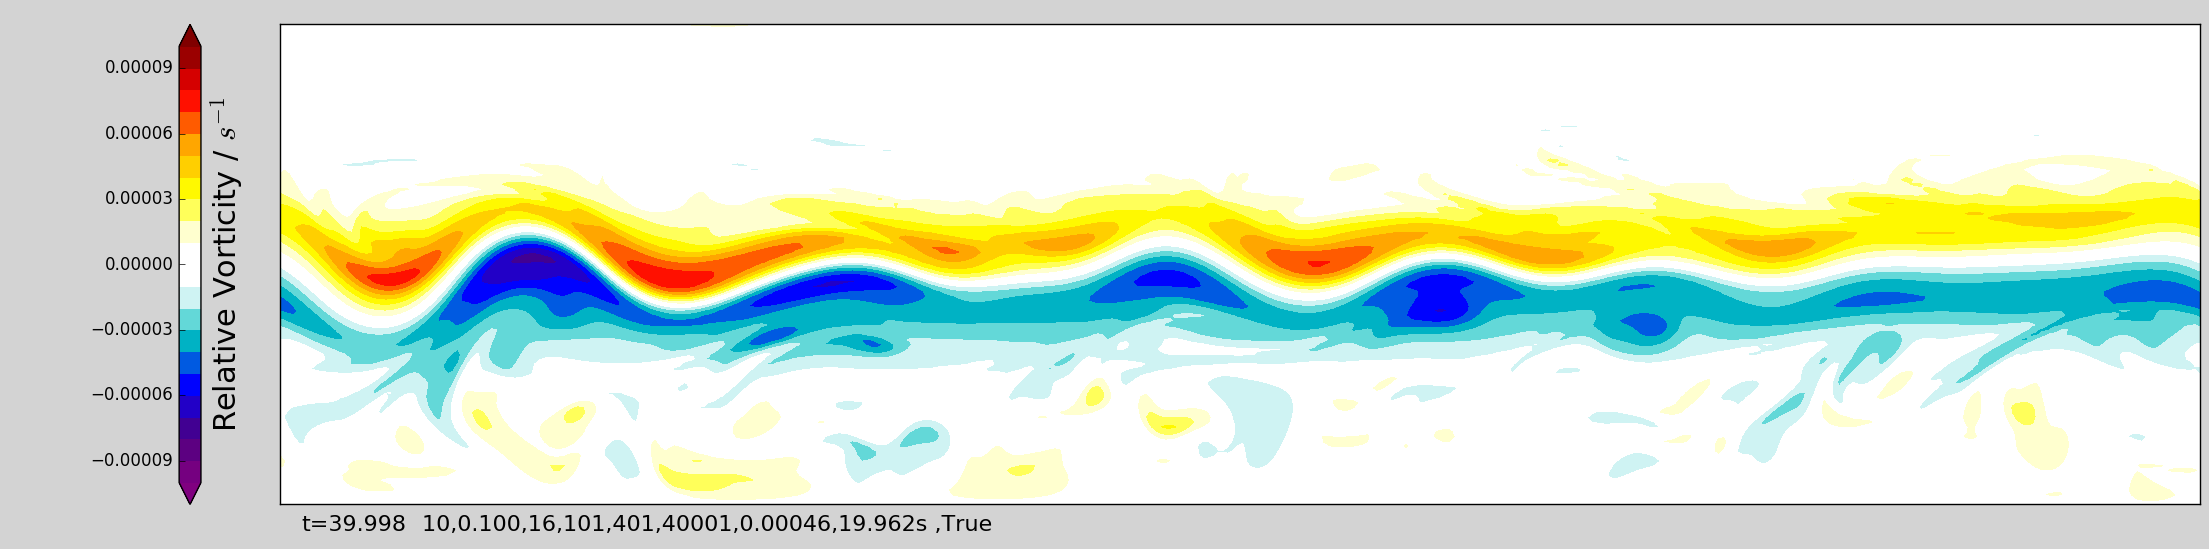

In [366]:
t=0
tplot=-100. # next time to make a plot
u=ui.copy()
v=vi.copy()
h=hip.copy()

dudt = 0.*u
dvdt = 0.*v
dhdt = 0.*h
dundt = 0.*u
dvndt = 0.*v
dhndt = 0.*h

dhdta = [None]*3
dudta = [None]*3
dvdta = [None]*3

nstep = 0
myfig = plt.figure(figsize=(24,6),facecolor='lightgrey')
ax2 = myfig.add_axes([0.1, 0.1, 0.8, .8]) # contour axes
ax3 = myfig.add_axes([0.01, 0.1, 0.08, .8]) # for colorbar
ax3.axis('off')
cmap = LinearSegmentedColormap.from_list('mycmap',['purple','indigo','b','c','w','w','yellow','orange','r','maroon'])
cmap.set_under('purple')
cmap.set_over('maroon')
plt.setp( ax2.get_xticklabels(), visible=False);

nxc=Nx//2
nyc=Ny//2
nrgstore,hstore,vortstore,tstore,potvortstore,ensstore = np.zeros(nsteps+2),np.zeros(nsteps+2),np.zeros(nsteps+2),np.zeros(nsteps+2),np.zeros(nsteps+2),np.zeros(nsteps+2)
hstore[0] = np.mean(h) #h[nyc,nxc]
vort = vorticity(u,v,dx,dy)
vortstore[0] = np.mean(vort) #vorticity(u,v,dx,dy)[nyc,nxc]
hu = p2u(h)
vortu = p2u(vort)
potvort = (fcoriolis+vortu)/hu
potvortstore[0] = np.mean(potvort)
ensstore[0] = 0.5*np.mean(potvort**2)
tstore[0] = 0 # for storing the corresponding time of the value

if varStep == True:
    dt = dti

vort = vorticity(u,v,dx,dy)
vortplot = vort/(L_scale/c_scale) 

while t < tstop + dt/2. or nstep == nsteps:
    nstep+=1
    abnow=min(nstep,aborder)
    if t >= tplot + dplot or nstep == nsteps: #plot
        plot(xp,yp,vortplot,mylevs,xu,vd,yu,u,ymax,xmax,v,speedmax,expt,cmap,fnamestr)
        tplot = t
    
    hu = p2u(h) # calculate h on the u grid
    
    dhdt = -divergence(u*hu,v*hu,dx,dy)
    
    dudt,dvdt = pgf(h,dx,dy) #pressure gradient force
    #prevPdudt,prevPdvdt=dudt.copy(),dvdt.copy()
    
    
    dudt += advect3(u,u,v,dx,dy,'u') # no option for other than 3rd order 
    dvdt += advect3(v,u,v,dx,dy,'v') 
    #prevAdudt,prevAdvdt=dudt.copy(),dvdt.copy()
    
#Coriolis force here:
    dudt += fcoriolis*v
    dvdt[1:-1,:] += -fcoriolis[1:-1,:]*u[1:-1,:]
#end Coriolis force
    
    dudta = [dudt.copy()] + dudta[:-1]
    dvdta = [dvdt.copy()] + dvdta[:-1]
    dhdta = [dhdt.copy()] + dhdta[:-1]
    
    if aborder == 10: #FORWARDS BACKWARDS
        fba = forback([u,v,h],dt,[dudta[0],dvdta[0],dhdta[0]],dx,dy,fcoriolis)
        u = fba[0]
        v = fba[1]
        h = fba[2]
    else: #ADAMS BASHFORTH
        u += dt*ab_blend(dudta,abnow)
        v += dt*ab_blend(dvdta,abnow)
        h += dt*ab_blend(dhdta,abnow)
    
    #v[0,:]=0.
    #v[-1,:]=0.
    
#NRG CONS
    h2 = h**2
    u2 = u**2
    v2 = v**2
    uh = (u2[:-1,:-1]+u2[1:,1:])/2
    vh = (v2[:-1,:-1]+v2[1:,1:])/2
    nrg = (h*uh/2)+(h*vh/2)+(h2/2)
    nrgstore[nstep] = np.mean(nrg)
    
#END NRG CONS


#Monitor relative and potential vort
    vort = vorticity(u,v,dx,dy)
    vortplot = vort/(L_scale/c_scale) 
    vortstore[nstep] = np.mean(vort)
    vortu = p2u(vort)
    potvort = (fcoriolis+vortu)/hu
    potvortstore[nstep] = np.mean(potvort)
    ensstore[nstep] = 0.5*np.mean(potvort**2)
#end monitoring
    
    t = t + dt
    hstore[nstep] = np.mean(h)
    tstore[nstep] = t
    if varStep == True:
        dt = dt*c
        
    v[0,:] = 0.
    v[-1,:] = 0.
    
    assert u.max()<2.e10, 'kaboom!'
    
#print('hu:',hu[0,:],hu[-1,:])
#print('dhdt:',dhdt[0,:],dhdt[-1,:])
#print('PGF dudt:',prevPdudt[0,:],prevPdudt[-1,:])
#print('PGF dvdt:',prevPdvdt[0,:],prevPdvdt[-1,:])
#print('ADV dudt:',prevAdudt[0,:]-prevPdudt[0,:],prevAdudt[-1,:]-prevPdudt[-1,:])
#print('ADV dvdt:',prevAdvdt[0,:]-prevPdvdt[0,:],prevAdvdt[-1,:]-prevPdvdt[-1,:])
#print('COR dudt:',dudt[0,:]-prevAdudt[0,:],dudt[-1,:]-prevAdudt[-1,:])
#print('COR dvdt:',dvdt[0,:]-prevAdvdt[0,:],dvdt[-1,:]-prevAdvdt[-1,:])
#print('u:',u[0,:],u[-1,:])
#print('v:',v[0,:],v[-1,:])
#print('h:',h[0,:],h[-1,:])

np.save(fnamestr+'_u',u)
np.save(fnamestr+'_v',v)
np.save(fnamestr+'_h',h)
np.save(fnamestr+'_hu',hu)
np.save(fnamestr+'_dhdt',dhdt)
np.save(fnamestr+'_dudt',dudt)
np.save(fnamestr+'_dvdt',dvdt)
np.save(fnamestr+'_vort',vort)
np.save(fnamestr+'_potvort',potvort)
np.save(fnamestr+'_nrg',nrg)
np.save(fnamestr+'_vortstore',np.array(vortstore))
np.save(fnamestr+'_potvortstore',np.array(potvortstore))
np.save(fnamestr+'_ensstore',np.array(ensstore))
np.save(fnamestr+'_hstore',np.array(hstore))
np.save(fnamestr+'_tstore',np.array(tstore))
np.save(fnamestr+'_nrgstore',np.array(nrgstore))
    
plt.close() 

In [367]:
print(nstep)

40002


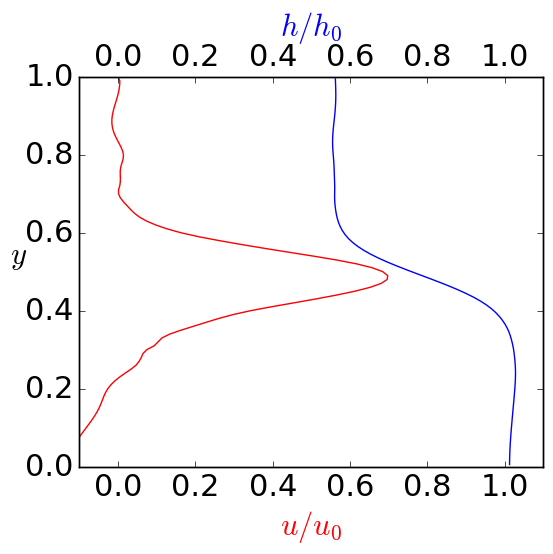

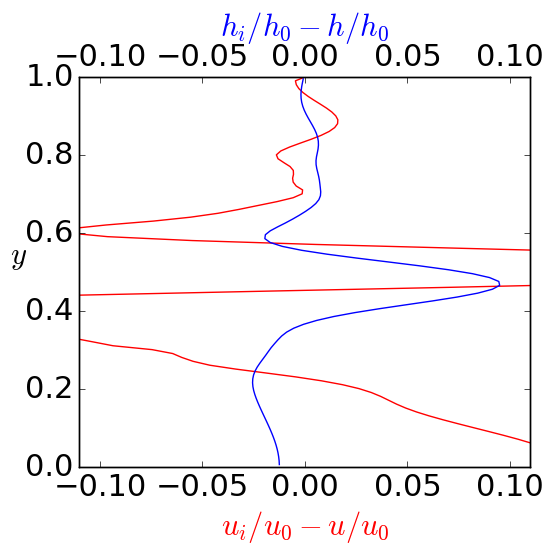

In [368]:
quick2,simpleb3 = plt.subplots(figsize=(6,6))
simpleb3.plot(u[:,200]/uo,yu[:,200],'r-')
simpleb3.set_xlabel('$u/u_0$',color='r')
simpleb3.set_ylabel('$y$',rotation=360)
simpleb4 = simpleb3.twiny()
simpleb4.plot(h[:,200]/ho,yp[:,200],'b-')
simpleb4.set_xlabel('$h/h_0$',color='b')
simpleb3.set_xlim(-0.1,1.1)
simpleb4.set_xlim(-0.1,1.1)
plt.tight_layout()
plt.savefig('finaluhSquare'+fnamestr+'.png')

quick3,simpleb5 = plt.subplots(figsize=(6,6))
simpleb5.plot((ui[:,200]/uo)-(u[:,200]/uo),yu[:,200],'r-')
simpleb5.set_xlabel('$u_i/u_0 - u/u_0$',color='r')
simpleb5.set_ylabel('$y$',rotation=360)
simpleb6 = simpleb5.twiny()
simpleb6.plot((hip[:,200]/ho)-(h[:,200]/ho),yp[:,200],'b-')
simpleb6.set_xlabel('$h_i/h_0 - h/h_0$',color='b')
simpleb5.set_xlim(-0.11,0.11)
simpleb6.set_xlim(-0.11,0.11)
plt.tight_layout()
plt.savefig('finaluhSquareComp'+fnamestr+'.png')


In [9]:
def rmse(act,forc):
    return np.sqrt(np.mean((forc - act)**2))
def rmse2(act,forc):
    return np.sqrt(np.mean((forc - act)**2))/np.sqrt(np.mean(act**2))
def l2norm(act,forc):
    return np.linalg.norm(forc-act)
#L2 error norm, divide by rms of just the act

In [10]:
import csv
with open('L2_VALUES.csv','a') as file:
        o = csv.writer(file,lineterminator='\n')
        o.writerow(['Run Name','u','v','h','hu','dhdt','dudt','dvdt','Rel Vort','Energy','Pot Vort'])
things = ['FB_Cons_CFL0p1','FB_Cons_CFL0p2','FB_Cons_CFL0p3','FB_Var2_CFL0p3','FB_Var3_CFL0p3','FB_Var4_CFL0p3','FB_Var2_CFL0p2','FB_Var3_CFL0p2','FB_Var4_CFL0p2','FB_Var2_CFL0p1','FB_Var3_CFL0p1','FB_Var4_CFL0p1']
for thing in things:
    rmse_u = l2norm(np.load('HR_u.npy'),np.load(thing+'_u.npy'))
    rmse_v = l2norm(np.load('HR_v.npy'),np.load(thing+'_v.npy'))
    rmse_h = l2norm(np.load('HR_h.npy'),np.load(thing+'_h.npy'))
    rmse_hu = l2norm(np.load('HR_hu.npy'),np.load(thing+'_hu.npy'))
    rmse_dhdt = l2norm(np.load('HR_dhdt.npy'),np.load(thing+'_dhdt.npy'))
    rmse_dudt = l2norm(np.load('HR_dudt.npy'),np.load(thing+'_dudt.npy'))
    rmse_dvdt = l2norm(np.load('HR_dvdt.npy'),np.load(thing+'_dvdt.npy'))
    rmse_vort = l2norm(np.load('HR_vort.npy'),np.load(thing+'_vort.npy'))
    rmse_nrg = l2norm(np.load('HR_nrg.npy'),np.load(thing+'_nrg.npy'))
    rmse_potvort = l2norm(np.load('HR_potvort.npy'),np.load(thing+'_potvort.npy'))
    with open('L2_VALUES.csv','a') as file:
        o = csv.writer(file,lineterminator='\n')
        o.writerow([thing,rmse_u,rmse_v,rmse_h,rmse_hu,rmse_dhdt,rmse_dudt,rmse_dvdt,rmse_vort,rmse_nrg,rmse_potvort])

In [370]:
if not highres:
    rmse_u = rmse(np.load('HR_u.npy'),u)
    rmse_v = rmse(np.load('HR_v.npy'),v)
    rmse_h = rmse(np.load('HR_h.npy'),h)
    rmse_hu = rmse(np.load('HR_hu.npy'),hu)
    rmse_dhdt = rmse(np.load('HR_dhdt.npy'),dhdt)
    rmse_dudt = rmse(np.load('HR_dudt.npy'),dudt)
    rmse_dvdt = rmse(np.load('HR_dvdt.npy'),dvdt)
    rmse_vort = rmse(np.load('HR_vort.npy'),vort)
    rmse_nrg = rmse(np.load('HR_nrg.npy'),nrg)
    rmse_potvort = rmse(np.load('HR_potvort.npy'),potvort)

In [371]:
import csv
with open('RMSE_VALUES.csv','a') as file:
    o = csv.writer(file,lineterminator='\n')
    if not highres:
        o.writerow([fnamestr,rmse_u,rmse_v,rmse_h,rmse_hu,rmse_dhdt,rmse_dudt,rmse_dvdt,rmse_vort,rmse_nrg,rmse_potvort])
    if highres:
        o.writerow(['Run Name','u','v','h','hu','dhdt','dudt','dvdt','Rel Vort','Energy','Pot Vort'])

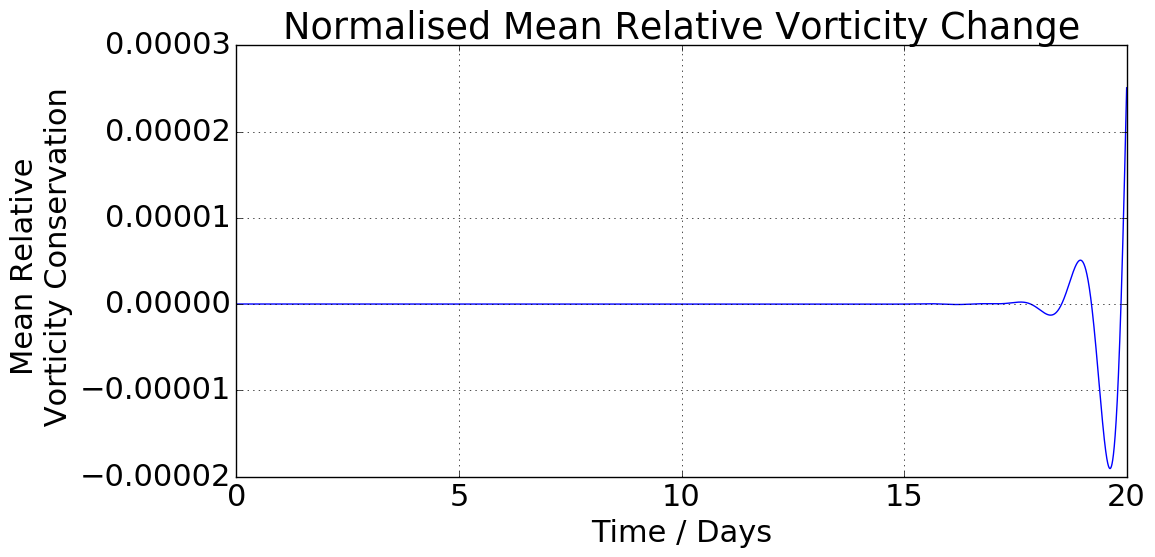

In [20]:
vortstore = np.load('Validation_vortstore.npy')
tstore = np.load('Validation_tstore.npy')

q3,vortplot = plt.subplots(figsize=(12,6))
vortplot.plot(tstore*t_scale,(vortstore*(c_scale/(L_scale*H_scale))-(vortstore[0]*(c_scale/(L_scale*H_scale))))/vortstore[0]*(c_scale/(L_scale*H_scale)))
#vortplot.set_ylim((8,9))
vortplot.set_title('Normalised Mean Relative Vorticity Change')
vortplot.set_xlim((0,tstop*t_scale))
vortplot.set_xlabel('Time / Days')
vortplot.set_ylabel('Mean Relative \n Vorticity Conservation')
vortplot.grid()
q3.tight_layout()
q3.savefig('meanvorttime'+fnamestr+'.png')

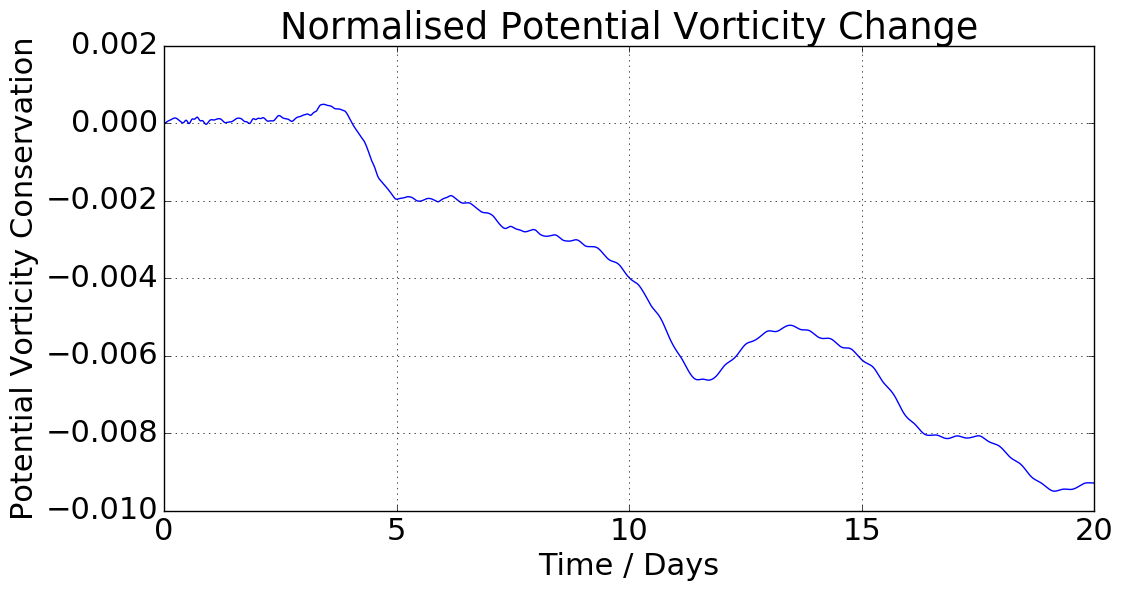

In [373]:
q4,potvortplot = plt.subplots(figsize=(12,6))
potvortplot.plot(tstore*t_scale,((potvortstore/(L_scale*c_scale))-(potvortstore[0]/(L_scale*c_scale)))/(potvortstore[0]/(L_scale*c_scale)))
#potvortplot.set_ylim((8,9))
potvortplot.set_title('Normalised Potential Vorticity Change')
potvortplot.set_xlim((0,tstop*t_scale))
potvortplot.set_xlabel('Time / Days')
potvortplot.set_ylabel('Potential Vorticity Conservation')
potvortplot.grid()
q4.savefig('meanpotvorttime'+fnamestr+'.png')

0.334827770408 0.334832372031


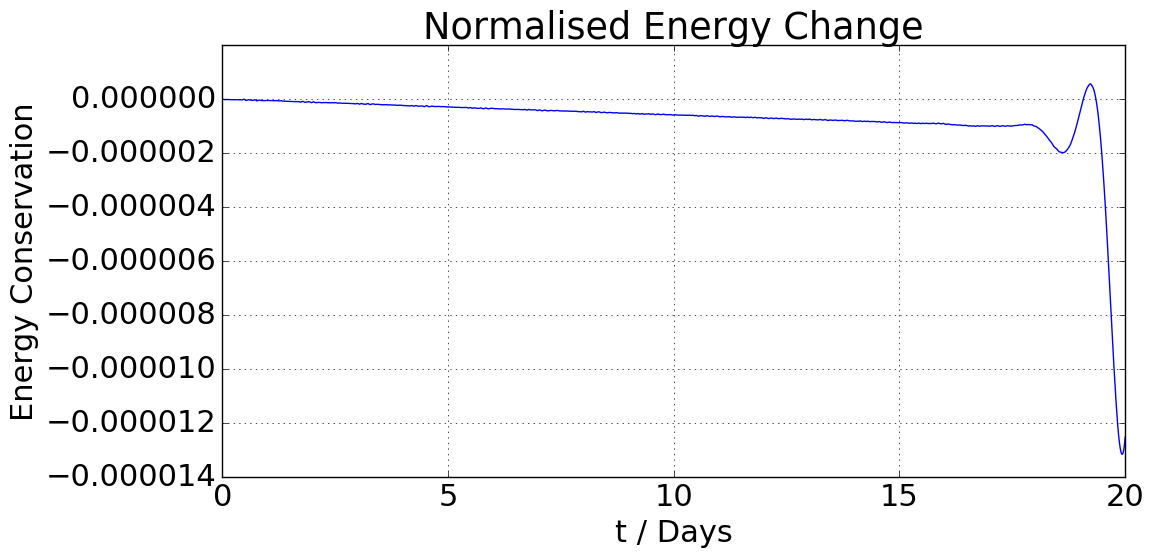

In [18]:
myfig, trace = plt.subplots(figsize=(12,6))
trace.plot(tstore[1:]*t_scale,(nrgstore[1:]-nrgstore[1])/nrgstore[1])
trace.set_title('Normalised Energy Change')
trace.set_xlabel('t / Days')
trace.set_ylabel('Energy Conservation')
trace.set_xlim(0,tstop*t_scale)
trace.grid()
print(min(nrgstore[1:]),max(nrgstore[1:]))
myfig.tight_layout()
myfig.savefig('EnergyCons'+fnamestr+'.png')

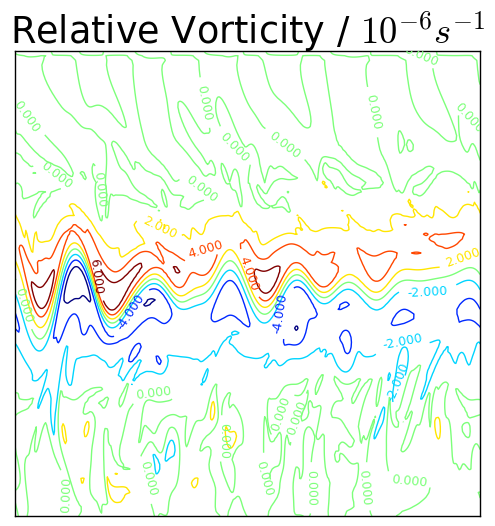

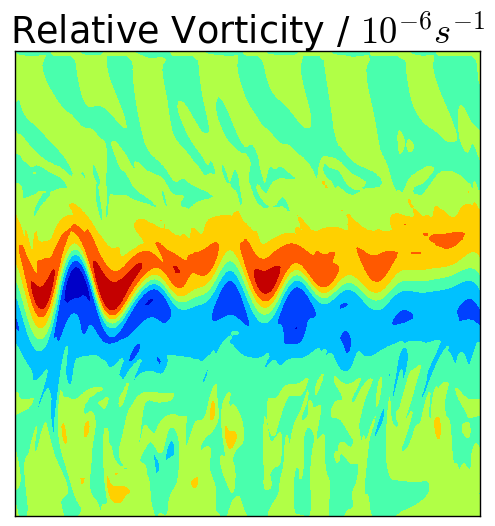

In [375]:
vort=vorticity(u,v,dx,dy)/(L_scale/c_scale) * 100000 # fix the vorticity function!!
quick,simple = plt.subplots(figsize=(6,6))
# it is possible to use both filled and line contour plots together
#simple.contourf(vort) # fiiled contours
CV = simple.contour(vort) # line contours
plt.clabel(CV, fontsize=9, inline=1) #labels on line contours
simple.set_title('Relative Vorticity / $ 10^{-6} s^{-1} $') #fix title
simple.set_yticklabels([])
simple.set_xticklabels([])
simple.xaxis.set_ticks_position('none') 
simple.yaxis.set_ticks_position('none')             
quick.savefig("vortline_"+fnamestr+".png")
quick2,simple2 = plt.subplots(figsize=(6,6))
# it is possible to use both filled and line contour plots together
simple2.contourf(vort) # fiiled contours
simple2.set_title('Relative Vorticity / $ 10^{-6} s^{-1} $') #fix title
simple2.set_yticklabels([])
simple2.set_xticklabels([])
simple2.xaxis.set_ticks_position('none') 
simple2.yaxis.set_ticks_position('none')           
quick2.savefig("vertcolour_"+fnamestr+".png")

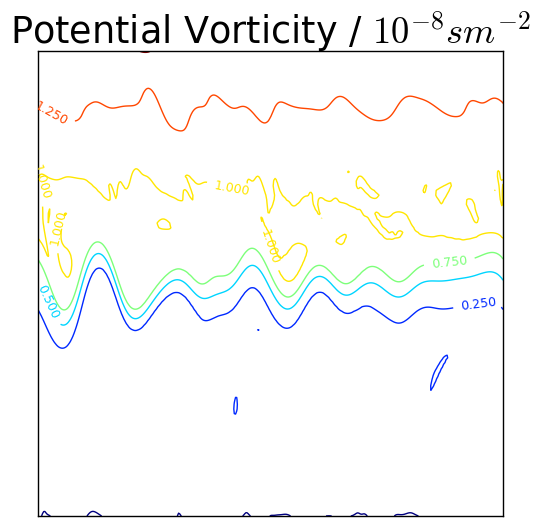

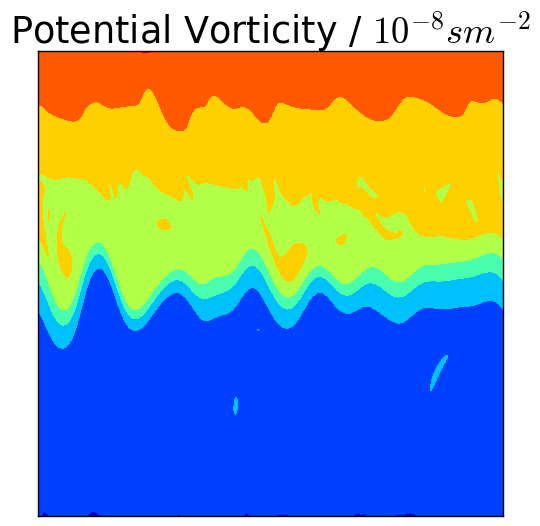

In [376]:
vort=vorticity(u,v,dx,dy) # fix the vorticity function!!
vortu = p2u(vort)
hu = p2u(h)
potvort = (((fcoriolis+vortu)/hu)/(L_scale*c_scale))*10**8
quick,simple = plt.subplots(figsize=(6,6))
# it is possible to use both filled and line contour plots together
#simple.contourf(vort) # fiiled contours
CV = simple.contour(potvort) # line contours
plt.clabel(CV, fontsize=9, inline=1) #labels on line contours
simple.set_title('Potential Vorticity / $ 10^{-8} sm^{-2} $') #fix title
simple.set_yticklabels([])
simple.set_xticklabels([])
simple.xaxis.set_ticks_position('none') 
simple.yaxis.set_ticks_position('none')             
quick.savefig("potvortline_"+fnamestr+".png")
quick2,simple2 = plt.subplots(figsize=(6,6))
# it is possible to use both filled and line contour plots together
simple2.contourf(potvort) # fiiled contours
simple2.set_title('Potential Vorticity / $ 10^{-8} sm^{-2} $') #fix title
simple2.set_yticklabels([])
simple2.set_xticklabels([])
simple2.xaxis.set_ticks_position('none') 
simple2.yaxis.set_ticks_position('none')           
quick2.savefig("potvortcolour_"+fnamestr+".png")

138.626495935 143.981201167


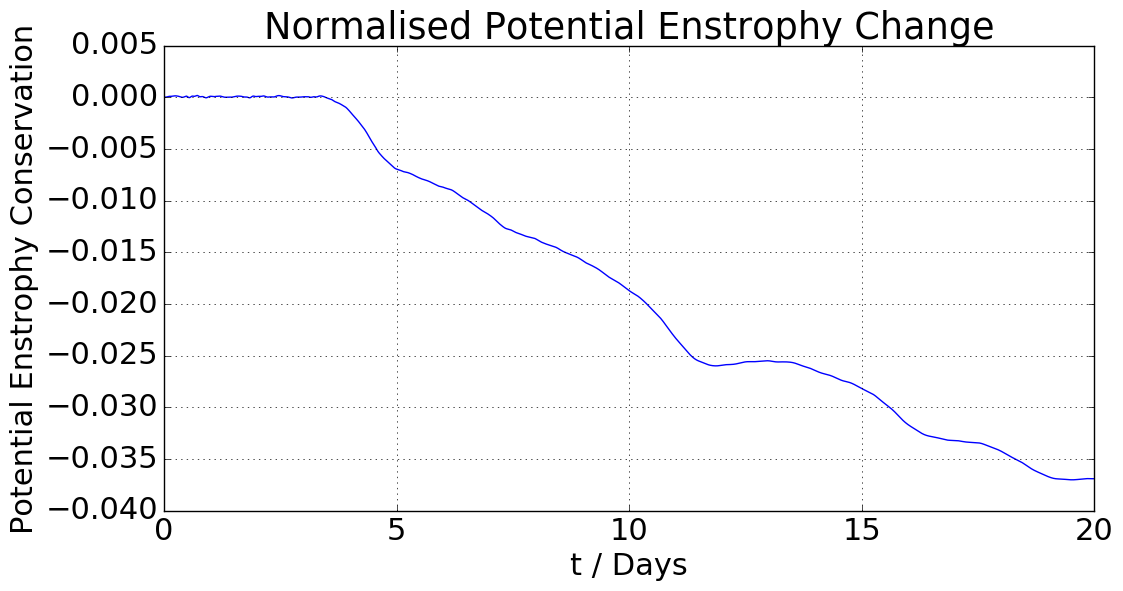

In [377]:
q5, ensplot = plt.subplots(figsize=(12,6))
ensplot.plot(tstore*t_scale,((ensstore/(c_scale**2))-(ensstore[0]/(c_scale**2)))/(ensstore[0]/(c_scale**2)))
ensplot.set_title('Normalised Potential Enstrophy Change')
ensplot.set_xlabel('t / Days')
ensplot.set_ylabel('Potential Enstrophy Conservation')
ensplot.set_xlim(0,tstop*t_scale)
ensplot.grid()
print(min(ensstore),max(ensstore))
q5.savefig('EnstrophyCons'+fnamestr+'.png')

## Student tasks:

### 1. Derivation of the dimensionless model

Beginning with:
$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} 
+ v \frac{\partial u}{\partial y}= - g\frac{\partial h}{\partial x} + fv
$$

$$
\frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} 
+ v \frac{\partial v}{\partial y}= - g\frac{\partial h}{\partial y} - fu
$$

$$
\frac{\partial h}{\partial t} = - \frac{\partial (uh) }{\partial x} - \frac{\partial (vh) }{\partial y}
$$

Let's assume a square domain of dimensional size $L\times L$.
Using the time and length scales that we used for one-dimensional waves,
derive the following dimensionless equations  **using pencil and paper**.
The whole point of this is $g$ disappears and the boundary conditions will always be
at $x=0$,$x=1$,$y=0$ and $y=1$. 

$$
\frac{\partial u^*}{\partial t^*} + u^* \frac{\partial u^*}{\partial x^*} 
+ v^* \frac{\partial u^*}{\partial y^*}= - \frac{\partial h^*}{\partial x^*} + f^*v^*
$$

$$
\frac{\partial v^*}{\partial t^*} + u^* \frac{\partial v^*}{\partial x^*} 
+ v^* \frac{\partial v^*}{\partial y^*}= - \frac{\partial h^*}{\partial y^*} - f^*u^*
$$

$$
\frac{\partial h^*}{\partial t^*} = - \frac{\partial (u^*h^*) }{\partial x^*} - \frac{\partial (v^*h^*) }{\partial y^*}
$$



### 2. Global conservation of energy

Here is a global conserved quantity for two-dimensional shallow-water waves, a generalization of the energy we derived for one-dimensional waves:

$$ \int_{x=0}^{x=L}\int_{y=0}^{y=L} \left( h\frac{u^2}{2} + h\frac{v^2}{2} + g\frac{h^2}{2} \right)dx\, dy $$

The dimensionless version is: 
$$ \int_{x=0}^{x=1}\int_{y=0}^{y=1} \left( h\frac{u^2}{2} + h\frac{v^2}{2} + \frac{h^2}{2} \right)dx\, dy $$

Show the numerical (meaning python array) approximation of the above integral is conserved well in the model.

[redacted]

The energy is conserved to 6dp throughout the run 
### 3. Conservation of potential vorticity in parcels

From either the dimensionless or dimensional model equations, derive with pencil and paper:
$$
\frac{d}{dt}\frac{\xi+f}{h} = 0
$$
where
$$
\vort \equiv \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}
$$
So the potential vorticity $$\frac{\vort+f}{h}$$ does not change within a parcel of fluid.

In our initialization with the height initially stacked up at the center, there is no advection at the center,
so the potential vorticity should be invariant at the center point.

Finish the `vorticity` function and then monitor   $\frac{\vort+f}{h}$ at the central grid point, to investigte if the model keeps it invariant with time.

<img src="vortcenterstudy.png">
<img src="vertvortfix.png">

### 4.  Instability with high f

For stability and accuracy, the time-step $\Delta t$ is constrained to values that
are small enough to prevent a wave or parcel from moving across more than one grid cell
in one forward time step.

Another constraint is that inertial oscillations must be resolved in time.

For what values of $f\Delta t$ does the model blow up?

|$f$|dtlim|$\Delta t$|$f\Delta t$ | Blow up? |
|---|---|---|---|---|
| 10 | 0.2 | 0.002 | 0.02 | No |
| 20 | 0.2 | 0.002 | 0.04 | No |
| 100 | 0.2 | 0.002 | 0.2 | No |
| 1000 | 0.2 | 0.002  | 2 | Kaboom! |
| 10 | 0.5 | 0.005 | 0.05 | Kaboom! |
| 10 | 0.3 | 0.003 | 0.03 | No |
| 10 | 0.4 | 0.004 | 0.04 | Kaboom! |
| 100 | 0.3 | 0.003 | 0.3 | No |
| 1 | 0.3 | 0.003 | 0.003 | No |
| 0.1 | 0.3 | 0.003 | 0.0003 | No |
| 500 | 0.2 | 0.002 | 1.0 | Kaboom! |
| 20 | 0.3 | 0.003 | 0.06 | No |
| 200 | 0.3 | 0.003 | 0.6 | Kaboom! |
| 166 | 0.3 | 0.003 | 0.498| Kaboom! |
| 300 | 0.2 | 0.002 | 0.6 | Kaboom! |

Blowing up is much more dependent on dtlim than it is on f. A change of just 0.2 in how far a parcel can move across a grid cell causes the simulation to blow up while it took increasing f to 3 times its original size to cause the same effect

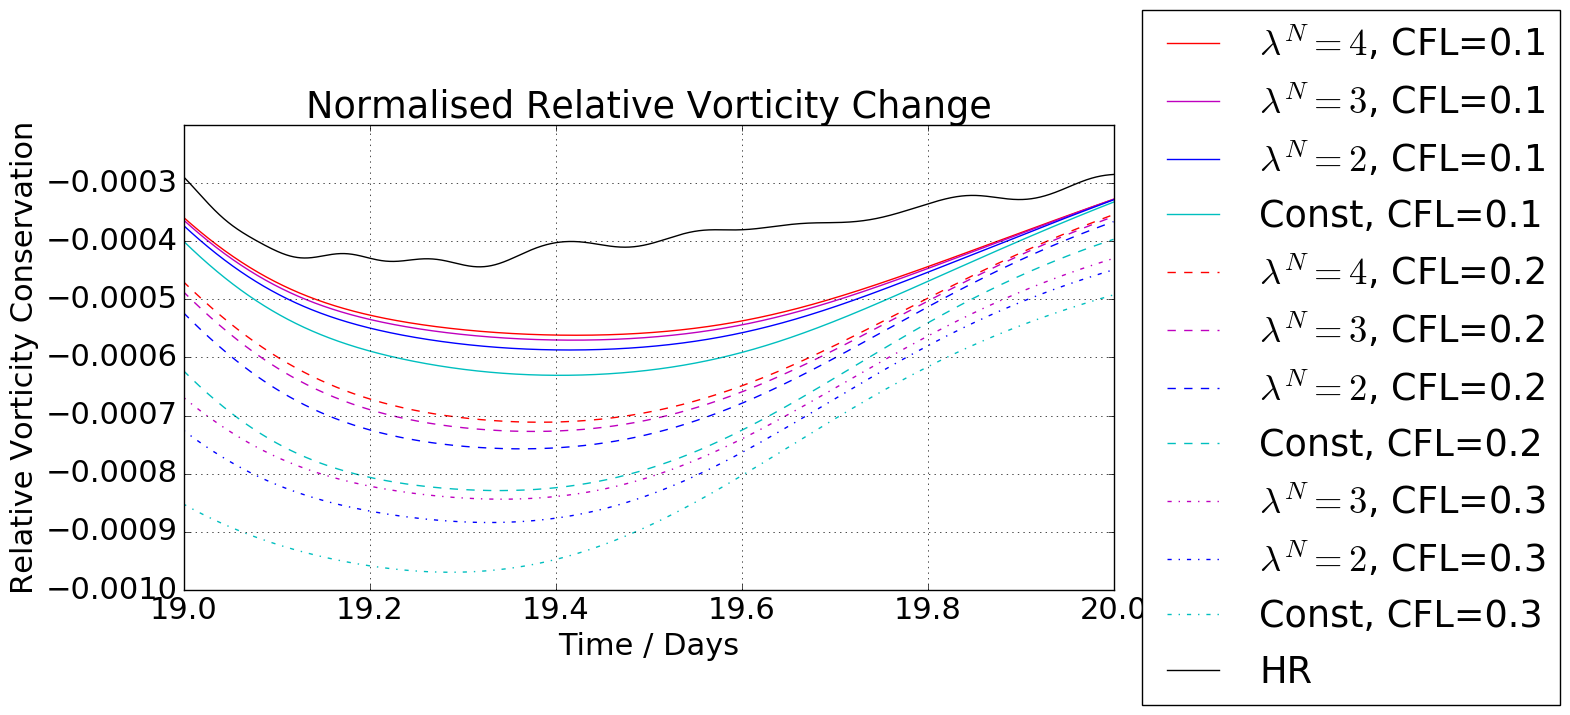

In [421]:
HR = np.load('HR_vortstore.npy')
HRt = np.load('HR_tstore.npy')
op14 = np.load('FB_Var4_CFL0p1_vortstore.npy')
op14t = np.load('FB_Var4_CFL0p1_tstore.npy')
op13 = np.load('FB_Var3_CFL0p1_vortstore.npy')
op13t = np.load('FB_Var3_CFL0p1_tstore.npy')
op12 = np.load('FB_Var2_CFL0p1_vortstore.npy')
op12t = np.load('FB_Var2_CFL0p1_tstore.npy')
op24 = np.load('FB_Var4_CFL0p2_vortstore.npy')
op24t = np.load('FB_Var4_CFL0p2_tstore.npy')
op23 = np.load('FB_Var3_CFL0p2_vortstore.npy')
op23t = np.load('FB_Var3_CFL0p2_tstore.npy')
op22 = np.load('FB_Var2_CFL0p2_vortstore.npy')
op22t = np.load('FB_Var2_CFL0p2_tstore.npy')
op34 = np.load('FB_Var4_CFL0p3_vortstore.npy')
op34t = np.load('FB_Var4_CFL0p3_tstore.npy')
op33 = np.load('FB_Var3_CFL0p3_vortstore.npy')
op33t = np.load('FB_Var3_CFL0p3_tstore.npy')
op32 = np.load('FB_Var2_CFL0p3_vortstore.npy')
op32t = np.load('FB_Var2_CFL0p3_tstore.npy')
op3 = np.load('FB_Cons_CFL0p3_vortstore.npy')
op3t = np.load('FB_Cons_CFL0p3_tstore.npy')
op2 = np.load('FB_Cons_CFL0p2_vortstore.npy')
op2t = np.load('FB_Cons_CFL0p2_tstore.npy')
op1 = np.load('FB_Cons_CFL0p1_vortstore.npy')
op1t = np.load('FB_Cons_CFL0p1_tstore.npy')

HR = (HR*(c_scale/(L_scale*H_scale))-(HR[0]*(c_scale/(L_scale*H_scale))))/HR[0]*(c_scale/(L_scale*H_scale))
op14 = (op14*(c_scale/(L_scale*H_scale))-(op14[0]*(c_scale/(L_scale*H_scale))))/op14[0]*(c_scale/(L_scale*H_scale))
op13 = (op13*(c_scale/(L_scale*H_scale))-(op13[0]*(c_scale/(L_scale*H_scale))))/op13[0]*(c_scale/(L_scale*H_scale))
op12 = (op12*(c_scale/(L_scale*H_scale))-(op12[0]*(c_scale/(L_scale*H_scale))))/op12[0]*(c_scale/(L_scale*H_scale))
op24 = (op24*(c_scale/(L_scale*H_scale))-(op24[0]*(c_scale/(L_scale*H_scale))))/op24[0]*(c_scale/(L_scale*H_scale))
op23 = (op23*(c_scale/(L_scale*H_scale))-(op23[0]*(c_scale/(L_scale*H_scale))))/op23[0]*(c_scale/(L_scale*H_scale))
op22 = (op22*(c_scale/(L_scale*H_scale))-(op22[0]*(c_scale/(L_scale*H_scale))))/op22[0]*(c_scale/(L_scale*H_scale))
op34 = (op34*(c_scale/(L_scale*H_scale))-(op34[0]*(c_scale/(L_scale*H_scale))))/op34[0]*(c_scale/(L_scale*H_scale))
op33 = (op33*(c_scale/(L_scale*H_scale))-(op33[0]*(c_scale/(L_scale*H_scale))))/op33[0]*(c_scale/(L_scale*H_scale))
op32 = (op32*(c_scale/(L_scale*H_scale))-(op32[0]*(c_scale/(L_scale*H_scale))))/op32[0]*(c_scale/(L_scale*H_scale))
op3 = (op3*(c_scale/(L_scale*H_scale))-(op3[0]*(c_scale/(L_scale*H_scale))))/op3[0]*(c_scale/(L_scale*H_scale))
op2 = (op2*(c_scale/(L_scale*H_scale))-(op2[0]*(c_scale/(L_scale*H_scale))))/op2[0]*(c_scale/(L_scale*H_scale))
op1 = (op1*(c_scale/(L_scale*H_scale))-(op1[0]*(c_scale/(L_scale*H_scale))))/op1[0]*(c_scale/(L_scale*H_scale))

q3,vortplot = plt.subplots(figsize=(12,6))
vortplot.plot(op14t*t_scale,op14,'r',label='$\lambda^N=4$, CFL=0.1')
vortplot.plot(op13t*t_scale,op13,'m',label='$\lambda^N=3$, CFL=0.1')
vortplot.plot(op12t*t_scale,op12,'b',label='$\lambda^N=2$, CFL=0.1')
vortplot.plot(op1t*t_scale,op1,'c',label='Const, CFL=0.1')
vortplot.plot(op24t*t_scale,op24,'r--',label='$\lambda^N=4$, CFL=0.2')
vortplot.plot(op23t*t_scale,op23,'m--',label='$\lambda^N=3$, CFL=0.2')
vortplot.plot(op22t*t_scale,op22,'b--',label='$\lambda^N=2$, CFL=0.2')
vortplot.plot(op2t*t_scale,op2,'c--',label='Const, CFL=0.2')
#vortplot.plot(op34t*t_scale,op34,'r-.',label='$\lambda^N=4$, CFL=0.3')
vortplot.plot(op33t*t_scale,op33,'m-.',label='$\lambda^N=3$, CFL=0.3')
vortplot.plot(op32t*t_scale,op32,'b-.',label='$\lambda^N=2$, CFL=0.3')
vortplot.plot(op3t*t_scale,op3,'c-.',label='Const, CFL=0.3')
vortplot.plot(HRt*t_scale,HR,'k',label='HR')
vortplot.set_title('Normalised Relative Vorticity Change')
vortplot.set_xlim((19,tstop*t_scale))
vortplot.set_ylim(-0.001,-0.0002)
vortplot.set_xlabel('Time / Days')
vortplot.set_ylabel('Relative Vorticity Conservation')
vortplot.grid()
lgd = vortplot.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
q3.savefig('ZoomedRelVortComp.png',bbox_extra_artists=(lgd,),bbox_inches='tight')

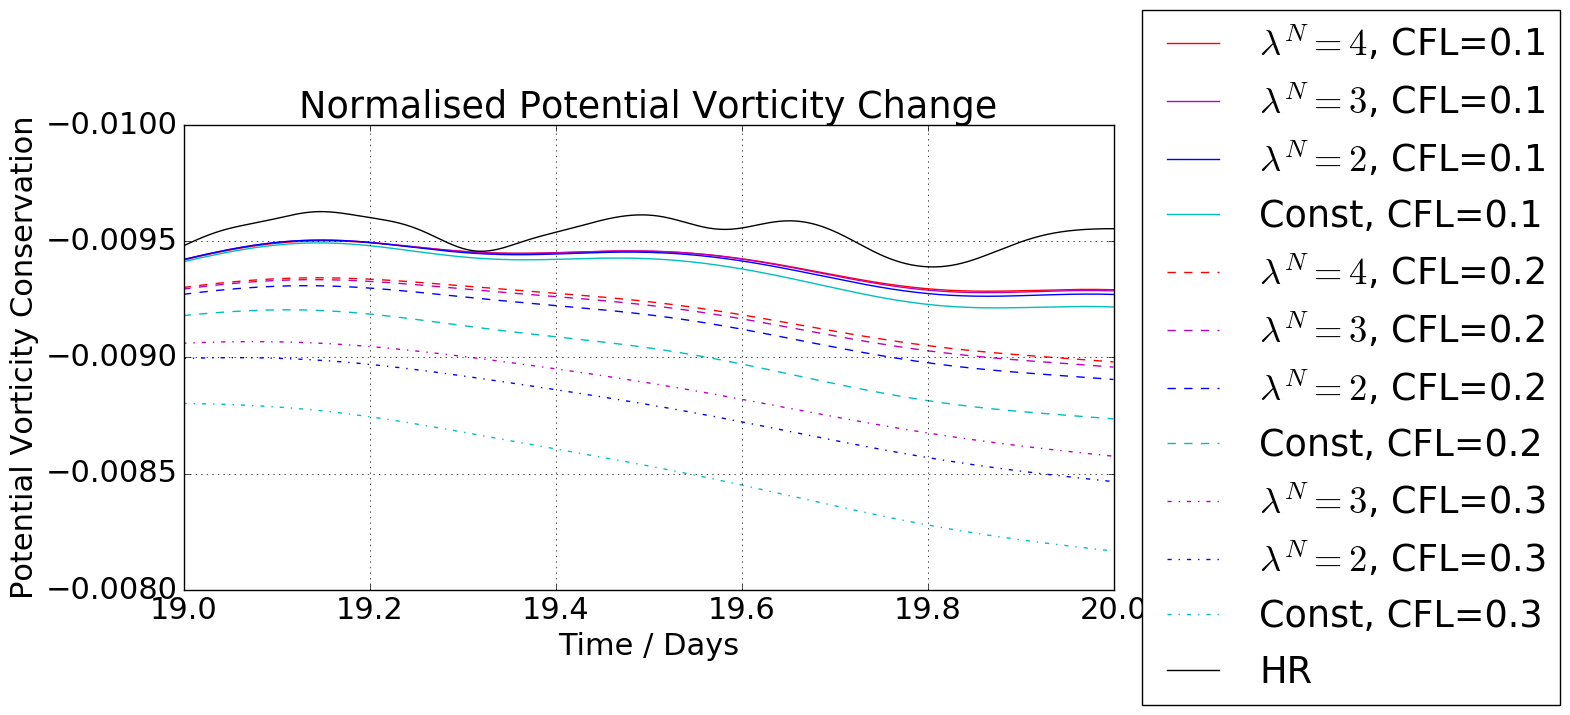

In [423]:
HR = np.load('HR_potvortstore.npy')
HRt = np.load('HR_tstore.npy')
op14 = np.load('FB_Var4_CFL0p1_potvortstore.npy')
op14t = np.load('FB_Var4_CFL0p1_tstore.npy')
op13 = np.load('FB_Var3_CFL0p1_potvortstore.npy')
op13t = np.load('FB_Var3_CFL0p1_tstore.npy')
op12 = np.load('FB_Var2_CFL0p1_potvortstore.npy')
op12t = np.load('FB_Var2_CFL0p1_tstore.npy')
op24 = np.load('FB_Var4_CFL0p2_potvortstore.npy')
op24t = np.load('FB_Var4_CFL0p2_tstore.npy')
op23 = np.load('FB_Var3_CFL0p2_potvortstore.npy')
op23t = np.load('FB_Var3_CFL0p2_tstore.npy')
op22 = np.load('FB_Var2_CFL0p2_potvortstore.npy')
op22t = np.load('FB_Var2_CFL0p2_tstore.npy')
op34 = np.load('FB_Var4_CFL0p3_potvortstore.npy')
op34t = np.load('FB_Var4_CFL0p3_tstore.npy')
op33 = np.load('FB_Var3_CFL0p3_potvortstore.npy')
op33t = np.load('FB_Var3_CFL0p3_tstore.npy')
op32 = np.load('FB_Var2_CFL0p3_potvortstore.npy')
op32t = np.load('FB_Var2_CFL0p3_tstore.npy')
op3 = np.load('FB_Cons_CFL0p3_potvortstore.npy')
op3t = np.load('FB_Cons_CFL0p3_tstore.npy')
op2 = np.load('FB_Cons_CFL0p2_potvortstore.npy')
op2t = np.load('FB_Cons_CFL0p2_tstore.npy')
op1 = np.load('FB_Cons_CFL0p1_potvortstore.npy')
op1t = np.load('FB_Cons_CFL0p1_tstore.npy')

HR = ((HR/(L_scale*c_scale))-(HR[0]/(L_scale*c_scale)))/(HR[0]/(L_scale*c_scale))
op14 = ((op14/(L_scale*c_scale))-(op14[0]/(L_scale*c_scale)))/(op14[0]/(L_scale*c_scale))
op13 = ((op13/(L_scale*c_scale))-(op13[0]/(L_scale*c_scale)))/(op13[0]/(L_scale*c_scale))
op12 = ((op12/(L_scale*c_scale))-(op12[0]/(L_scale*c_scale)))/(op12[0]/(L_scale*c_scale))
op24 = ((op24/(L_scale*c_scale))-(op24[0]/(L_scale*c_scale)))/(op24[0]/(L_scale*c_scale))
op23 = ((op23/(L_scale*c_scale))-(op23[0]/(L_scale*c_scale)))/(op23[0]/(L_scale*c_scale))
op22 = ((op22/(L_scale*c_scale))-(op22[0]/(L_scale*c_scale)))/(op22[0]/(L_scale*c_scale))
op34 = ((op34/(L_scale*c_scale))-(op34[0]/(L_scale*c_scale)))/(op34[0]/(L_scale*c_scale))
op33 = ((op33/(L_scale*c_scale))-(op33[0]/(L_scale*c_scale)))/(op33[0]/(L_scale*c_scale))
op32 = ((op32/(L_scale*c_scale))-(op32[0]/(L_scale*c_scale)))/(op32[0]/(L_scale*c_scale))
op3 = ((op3/(L_scale*c_scale))-(op3[0]/(L_scale*c_scale)))/(op3[0]/(L_scale*c_scale))
op2 = ((op2/(L_scale*c_scale))-(op2[0]/(L_scale*c_scale)))/(op2[0]/(L_scale*c_scale))
op1 = ((op1/(L_scale*c_scale))-(op1[0]/(L_scale*c_scale)))/(op1[0]/(L_scale*c_scale))

q4,potvortplot = plt.subplots(figsize=(12,6))
potvortplot.plot(op14t*t_scale,op14,'r',label='$\lambda^N=4$, CFL=0.1')
potvortplot.plot(op13t*t_scale,op13,'m',label='$\lambda^N=3$, CFL=0.1')
potvortplot.plot(op12t*t_scale,op12,'b',label='$\lambda^N=2$, CFL=0.1')
potvortplot.plot(op1t*t_scale,op1,'c',label='Const, CFL=0.1')
potvortplot.plot(op24t*t_scale,op24,'r--',label='$\lambda^N=4$, CFL=0.2')
potvortplot.plot(op23t*t_scale,op23,'m--',label='$\lambda^N=3$, CFL=0.2')
potvortplot.plot(op22t*t_scale,op22,'b--',label='$\lambda^N=2$, CFL=0.2')
potvortplot.plot(op2t*t_scale,op2,'c--',label='Const, CFL=0.2')
#potvortplot.plot(op34t*t_scale,op34,'r-.',label='$\lambda^N=4$, CFL=0.3')
potvortplot.plot(op33t*t_scale,op33,'m-.',label='$\lambda^N=3$, CFL=0.3')
potvortplot.plot(op32t*t_scale,op32,'b-.',label='$\lambda^N=2$, CFL=0.3')
potvortplot.plot(op3t*t_scale,op3,'c-.',label='Const, CFL=0.3')
potvortplot.plot(HRt*t_scale,HR,'k',label='HR')
potvortplot.set_title('Normalised Potential Vorticity Change')
potvortplot.set_xlim((19,tstop*t_scale))
potvortplot.set_xlabel('Time / Days')
potvortplot.set_ylabel('Potential Vorticity Conservation')
potvortplot.grid()
lgd = potvortplot.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
potvortplot.set_ylim(-0.008,-0.01)
q4.savefig('ZoomedPotVortComp.png',bbox_extra_artists=(lgd,),bbox_inches='tight')

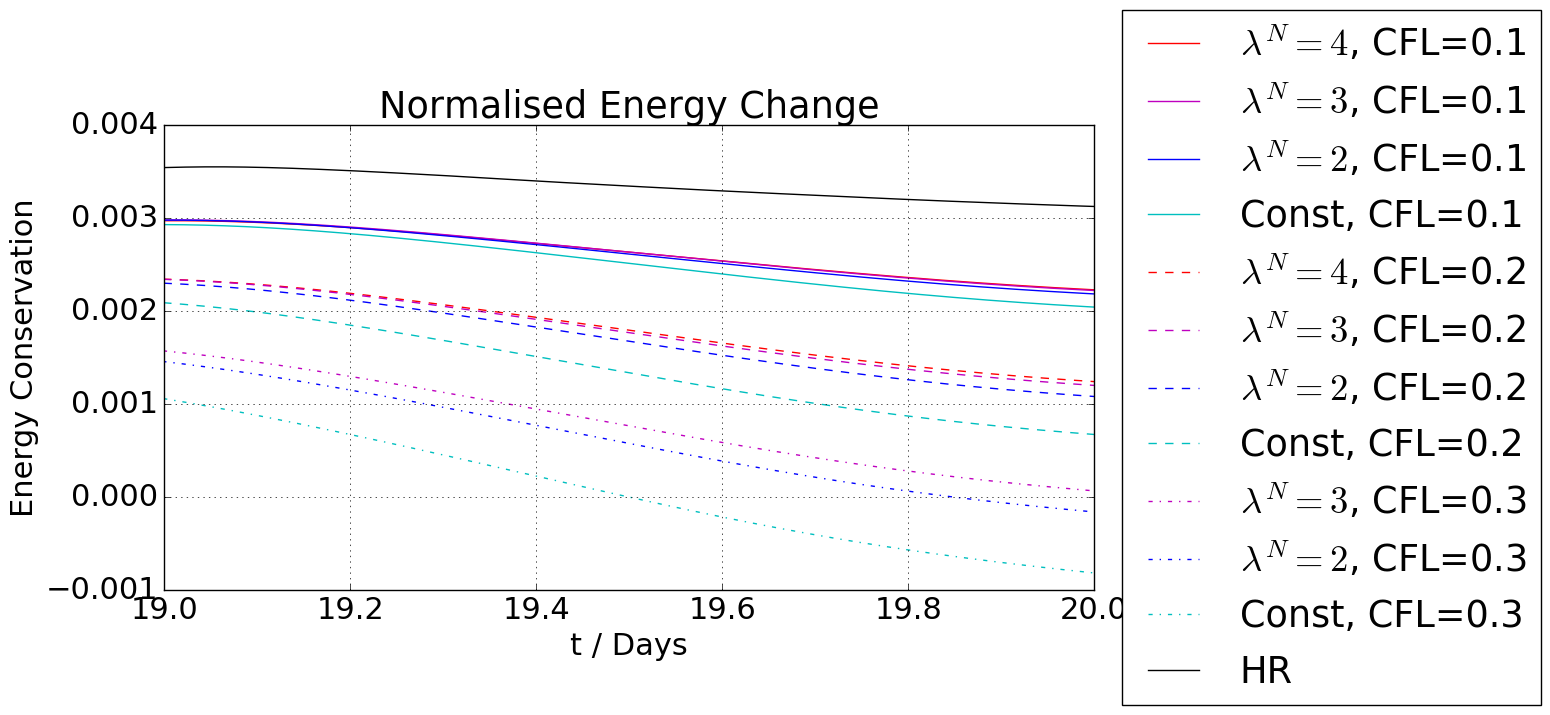

In [425]:
HR = np.load('HR_nrgstore.npy')
HRt = np.load('HR_tstore.npy')
op14 = np.load('FB_Var4_CFL0p1_nrgstore.npy')
op14t = np.load('FB_Var4_CFL0p1_tstore.npy')
op13 = np.load('FB_Var3_CFL0p1_nrgstore.npy')
op13t = np.load('FB_Var3_CFL0p1_tstore.npy')
op12 = np.load('FB_Var2_CFL0p1_nrgstore.npy')
op12t = np.load('FB_Var2_CFL0p1_tstore.npy')
op24 = np.load('FB_Var4_CFL0p2_nrgstore.npy')
op24t = np.load('FB_Var4_CFL0p2_tstore.npy')
op23 = np.load('FB_Var3_CFL0p2_nrgstore.npy')
op23t = np.load('FB_Var3_CFL0p2_tstore.npy')
op22 = np.load('FB_Var2_CFL0p2_nrgstore.npy')
op22t = np.load('FB_Var2_CFL0p2_tstore.npy')
op34 = np.load('FB_Var4_CFL0p3_nrgstore.npy')
op34t = np.load('FB_Var4_CFL0p3_tstore.npy')
op33 = np.load('FB_Var3_CFL0p3_nrgstore.npy')
op33t = np.load('FB_Var3_CFL0p3_tstore.npy')
op32 = np.load('FB_Var2_CFL0p3_nrgstore.npy')
op32t = np.load('FB_Var2_CFL0p3_tstore.npy')
op3 = np.load('FB_Cons_CFL0p3_nrgstore.npy')
op3t = np.load('FB_Cons_CFL0p3_tstore.npy')
op2 = np.load('FB_Cons_CFL0p2_nrgstore.npy')
op2t = np.load('FB_Cons_CFL0p2_tstore.npy')
op1 = np.load('FB_Cons_CFL0p1_nrgstore.npy')
op1t = np.load('FB_Cons_CFL0p1_tstore.npy')

HR = (HR[1:]-HR[1])/HR[1]
op14 = (op14[1:]-op14[1])/op14[1]
op13 = (op13[1:]-op13[1])/op13[1]
op12 = (op12[1:]-op12[1])/op12[1]
op24 = (op24[1:]-op24[1])/op24[1]
op23 = (op23[1:]-op23[1])/op23[1]
op22 = (op22[1:]-op22[1])/op22[1]
op34 = (op34[1:]-op34[1])/op34[1]
op33 = (op33[1:]-op33[1])/op33[1]
op32 = (op32[1:]-op32[1])/op32[1]
op3 = (op3[1:]-op3[1])/op3[1]
op2 = (op2[1:]-op2[1])/op2[1]
op1 = (op1[1:]-op1[1])/op1[1]

myfig, trace = plt.subplots(figsize=(12,6))
trace.plot(op14t[1:]*t_scale,op14,'r',label='$\lambda^N=4$, CFL=0.1')
trace.plot(op13t[1:]*t_scale,op13,'m',label='$\lambda^N=3$, CFL=0.1')
trace.plot(op12t[1:]*t_scale,op12,'b',label='$\lambda^N=2$, CFL=0.1')
trace.plot(op1t[1:]*t_scale,op1,'c',label='Const, CFL=0.1')
trace.plot(op24t[1:]*t_scale,op24,'r--',label='$\lambda^N=4$, CFL=0.2')
trace.plot(op23t[1:]*t_scale,op23,'m--',label='$\lambda^N=3$, CFL=0.2')
trace.plot(op22t[1:]*t_scale,op22,'b--',label='$\lambda^N=2$, CFL=0.2')
trace.plot(op2t[1:]*t_scale,op2,'c--',label='Const, CFL=0.2')
#trace.plot(op34t[1:]*t_scale,op34,'r-.',label='$\lambda^N=4$, CFL=0.3')
trace.plot(op33t[1:]*t_scale,op33,'m-.',label='$\lambda^N=3$, CFL=0.3')
trace.plot(op32t[1:]*t_scale,op32,'b-.',label='$\lambda^N=2$, CFL=0.3')
trace.plot(op3t[1:]*t_scale,op3,'c-.',label='Const, CFL=0.3')
trace.plot(HRt[1:]*t_scale,HR,'k',label='HR')
trace.set_title('Normalised Energy Change')
trace.set_xlabel('t / Days')
trace.set_ylabel('Energy Conservation')
trace.set_xlim(19,tstop*t_scale)
trace.grid()
lgd = trace.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
trace.set_ylim(-0.001,0.004)
myfig.savefig('ZoomedNRGComp.png',bbox_extra_artists=(lgd,),bbox_inches='tight')

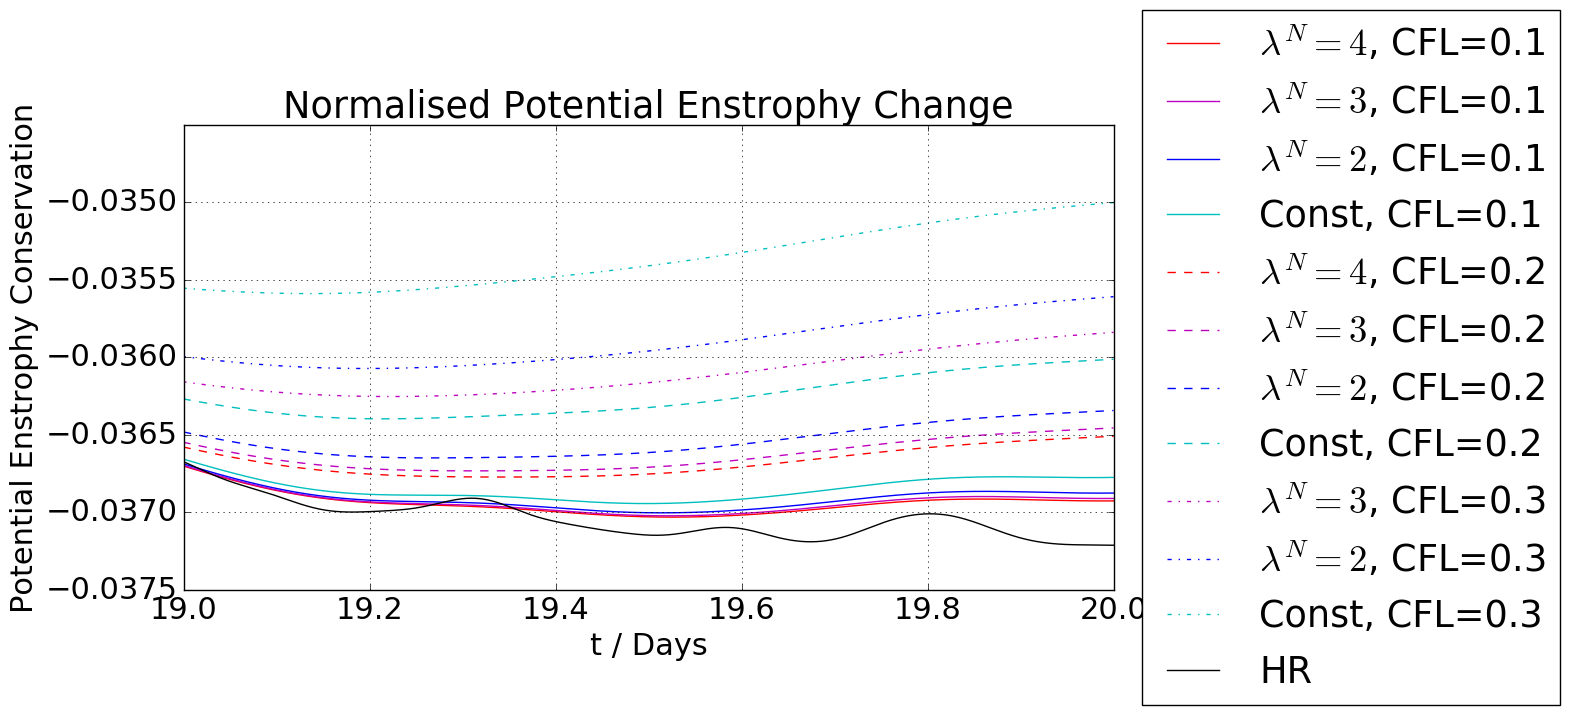

In [434]:
HR = np.load('HR_ensstore.npy')
HRt = np.load('HR_tstore.npy')
op14 = np.load('FB_Var4_CFL0p1_ensstore.npy')
op14t = np.load('FB_Var4_CFL0p1_tstore.npy')
op13 = np.load('FB_Var3_CFL0p1_ensstore.npy')
op13t = np.load('FB_Var3_CFL0p1_tstore.npy')
op12 = np.load('FB_Var2_CFL0p1_ensstore.npy')
op12t = np.load('FB_Var2_CFL0p1_tstore.npy')
op24 = np.load('FB_Var4_CFL0p2_ensstore.npy')
op24t = np.load('FB_Var4_CFL0p2_tstore.npy')
op23 = np.load('FB_Var3_CFL0p2_ensstore.npy')
op23t = np.load('FB_Var3_CFL0p2_tstore.npy')
op22 = np.load('FB_Var2_CFL0p2_ensstore.npy')
op22t = np.load('FB_Var2_CFL0p2_tstore.npy')
op34 = np.load('FB_Var4_CFL0p3_ensstore.npy')
op34t = np.load('FB_Var4_CFL0p3_tstore.npy')
op33 = np.load('FB_Var3_CFL0p3_ensstore.npy')
op33t = np.load('FB_Var3_CFL0p3_tstore.npy')
op32 = np.load('FB_Var2_CFL0p3_ensstore.npy')
op32t = np.load('FB_Var2_CFL0p3_tstore.npy')
op3 = np.load('FB_Cons_CFL0p3_ensstore.npy')
op3t = np.load('FB_Cons_CFL0p3_tstore.npy')
op2 = np.load('FB_Cons_CFL0p2_ensstore.npy')
op2t = np.load('FB_Cons_CFL0p2_tstore.npy')
op1 = np.load('FB_Cons_CFL0p1_ensstore.npy')
op1t = np.load('FB_Cons_CFL0p1_tstore.npy')

HR = ((HR/(c_scale**2))-(HR[0]/(c_scale**2)))/(HR[0]/(c_scale**2))
op14 = ((op14/(c_scale**2))-(op14[0]/(c_scale**2)))/(op14[0]/(c_scale**2))
op13 = ((op13/(c_scale**2))-(op13[0]/(c_scale**2)))/(op13[0]/(c_scale**2))
op12 = ((op12/(c_scale**2))-(op12[0]/(c_scale**2)))/(op12[0]/(c_scale**2))
op24 = ((op24/(c_scale**2))-(op24[0]/(c_scale**2)))/(op24[0]/(c_scale**2))
op23 = ((op23/(c_scale**2))-(op23[0]/(c_scale**2)))/(op23[0]/(c_scale**2))
op22 = ((op22/(c_scale**2))-(op22[0]/(c_scale**2)))/(op22[0]/(c_scale**2))
op34 = ((op34/(c_scale**2))-(op34[0]/(c_scale**2)))/(op34[0]/(c_scale**2))
op33 = ((op33/(c_scale**2))-(op33[0]/(c_scale**2)))/(op33[0]/(c_scale**2))
op32 = ((op32/(c_scale**2))-(op32[0]/(c_scale**2)))/(op32[0]/(c_scale**2))
op3 = ((op3/(c_scale**2))-(op3[0]/(c_scale**2)))/(op3[0]/(c_scale**2))
op2 = ((op2/(c_scale**2))-(op2[0]/(c_scale**2)))/(op2[0]/(c_scale**2))
op1 = ((op1/(c_scale**2))-(op1[0]/(c_scale**2)))/(op1[0]/(c_scale**2))

q5, ensplot = plt.subplots(figsize=(12,6))
ensplot.plot(op14t*t_scale,op14,'r',label='$\lambda^N=4$, CFL=0.1')
ensplot.plot(op13t*t_scale,op13,'m',label='$\lambda^N=3$, CFL=0.1')
ensplot.plot(op12t*t_scale,op12,'b',label='$\lambda^N=2$, CFL=0.1')
ensplot.plot(op1t*t_scale,op1,'c',label='Const, CFL=0.1')
ensplot.plot(op24t*t_scale,op24,'r--',label='$\lambda^N=4$, CFL=0.2')
ensplot.plot(op23t*t_scale,op23,'m--',label='$\lambda^N=3$, CFL=0.2')
ensplot.plot(op22t*t_scale,op22,'b--',label='$\lambda^N=2$, CFL=0.2')
ensplot.plot(op2t*t_scale,op2,'c--',label='Const, CFL=0.2')
#ensplot.plot(op34t*t_scale,op34,'r-.',label='$\lambda^N=4$, CFL=0.3')
ensplot.plot(op33t*t_scale,op33,'m-.',label='$\lambda^N=3$, CFL=0.3')
ensplot.plot(op32t*t_scale,op32,'b-.',label='$\lambda^N=2$, CFL=0.3')
ensplot.plot(op3t*t_scale,op3,'c-.',label='Const, CFL=0.3')
ensplot.plot(HRt*t_scale,HR,'k',label='HR')
ensplot.set_title('Normalised Potential Enstrophy Change')
ensplot.set_xlabel('t / Days')
ensplot.set_ylabel('Potential Enstrophy Conservation')
ensplot.set_xlim(19,tstop*t_scale)
ensplot.grid()
lgd = ensplot.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ensplot.set_ylim(-0.0375,-0.0345)
q5.savefig('ZoomedEnsComp.png',bbox_extra_artists=(lgd,),bbox_inches='tight')

In [411]:
#filenames = ['HR','FB_Cons_CFL0p1','FB_Cons_CFL0p2','FB_Cons_CFL0p3','FB_Var2_CFL0p3','FB_Var3_CFL0p3','FB_Var4_CFL0p3','FB_Var2_CFL0p2','FB_Var3_CFL0p2','FB_Var4_CFL0p2','FB_Var2_CFL0p1','FB_Var3_CFL0p1','FB_Var4_CFL0p1']
#
#for filename in filenames:
#    Loadhu = np.load(filename+'_hu.npy')
#    Loadvort = np.load(filename+'_vort.npy')
#    vortu = p2u(Loadvort)
#    potvort = (fcoriolis+vortu)/Loadhu
#    np.save(filename+'_potvort',potvort)
#
#for filename in filenames[1:]:
#    rmse_potvort = rmse(np.load('HR_potvort.npy'),np.load(filename+'_potvort.npy'))
#    with open('potvortRMSE.csv','a') as file:
#        o = csv.writer(file,lineterminator='\n')
#        o.writerow([filename,rmse_potvort])